# **Práctica 4: Clasificación semi-supervisada**
### Objetivo: El objetivo de esta práctica es introducir los conceptos de clasificación semi-supervisada
### Carlos Checa Moreno
### i02chmoc@uco.es

Cuaderno Google Colab: https://colab.research.google.com/drive/1JzJJ5ESMhGeAJCndQ7D6o45aXe_x2RtG?usp=sharing

# TAREA 1: Implementación de 1 método


Seleccione un algoritmo de los indicados en teoría que implemente aprendizaje semi-supervisado de cualquiera de los
paradigmas estudiados. Implemente el algoritmo.
Seleccione al menos un dataset semi-supervisado y evalúe el algoritmo implementado.
NOTA: En la entrega de la práctica se debe incluir la implementación en Python del método realizado.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import fetch_openml

Probaré el algoritmo con el dataset wine de sklearn. Descargo el dataset y escalo los datos.

In [ ]:
'''--------- Dataset ---------'''
data = fetch_openml(name='wine', version=1, as_frame=True)
df = data.frame
X = df.select_dtypes(include=[np.number])  # Solo columnas numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = LabelEncoder().fit_transform(df[df.columns[df.columns.str.contains('class', case=False)][0]])

# Dividir datos en entrenamiento y prueba
X_train, X_unlabeled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=38)

A continuación, elimino etiquetas del dataset para convertirlo en un conjunto de datos adecuado para aprendizaje semi-supervisado. Eliminaré un 50%.

In [ ]:
'''--------- Convertir en dataset con falta de etiquetas ---------'''
def remove_labels(y, pct, RNG):
    n_remove = int(len(y) * pct)
    remove_indices = RNG.choice(len(y), size=n_remove, replace=False)
    y_semi = y.copy()
    y_semi[remove_indices] = -1  # Etiquetas no disponibles
    return y_semi

RNG = np.random.default_rng(42)
y_train_semi = remove_labels(y_train, 0.5, RNG)

## Implementación Self-Training

In [ ]:
# Entrenar modelo inicial con solo datos etiquetados
labeled_indices = y_train_semi != -1
model = SVC(probability=True, kernel='rbf')
model.fit(X_train[labeled_indices], y_train_semi[labeled_indices])

threshold = 0.9  # Umbral de confianza para pseudo-etiquetado
for _ in range(5):  # Número de iteraciones
    # Verificar si aún hay muestras no etiquetadas
    if np.sum(~labeled_indices) == 0:
        print("No quedan muestras no etiquetadas. Deteniendo el proceso.")
        break
    
    probs = model.predict_proba(X_train[~labeled_indices])
    max_probs = np.max(probs, axis=1)
    pseudo_labels = np.argmax(probs, axis=1)
    
    confident_indices = max_probs > threshold
    if np.sum(confident_indices) == 0:
        print("No hay predicciones con suficiente confianza en esta iteración.")
        break
    
    new_labeled_X = X_train[~labeled_indices][confident_indices]
    new_labeled_y = pseudo_labels[confident_indices]
    
    X_train = np.vstack((X_train[labeled_indices], new_labeled_X))
    y_train_semi = np.hstack((y_train_semi[labeled_indices], new_labeled_y))
    labeled_indices = np.ones(len(y_train_semi), dtype=bool) 
    
    # Reentrenar modelo
    model.fit(X_train, y_train_semi)

No quedan muestras no etiquetadas. Deteniendo el proceso.


In [ ]:
'''--------- Realizar predicciones con el conjunto de test ---------'''
y_pred = model.predict(X_unlabeled)
y_test_full = y_test 

## Evaluación del modelo

Vemos que obtenemos unos resultados bastantes buenos de 0.984 en todas las métricas ya que solo se han etiquetado mal 2 instancias de 2 clases diferentes. 

Confusion Matrix:
[[43  0  0]
 [ 0 45  1]
 [ 0  1 35]]
Accuracy: 0.984
Precision: 0.984
Recall: 0.984
F1 Score: 0.984


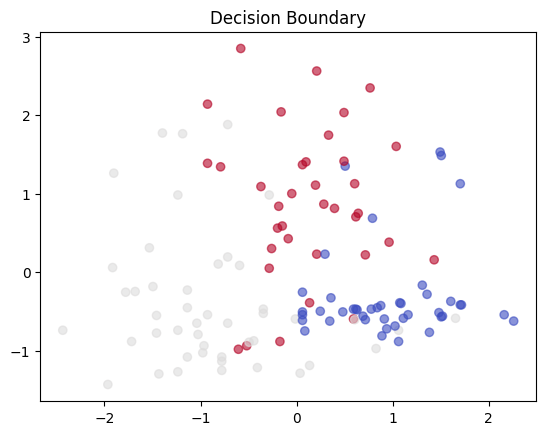

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test_full, y_pred))
print("Accuracy:", accuracy_score(y_test_full, y_pred))
print("Precision:", precision_score(y_test_full, y_pred, average='weighted'))
print("Recall:", recall_score(y_test_full, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test_full, y_pred, average='weighted'))

# Visualización de la frontera de decisión
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.title('Decision Boundary')
plt.show()


# Tarea 2: Comparación de métodos

Seleccione al menos dos algoritmos de los disponibles en la bibliotecas indicadas. Seleccione al menos tres problemas
semi-supervisados de los repositorios indicados.
Realice las siguientes tareas:
1. Aplique los algoritmos seleccionados a los datasets
2. Compare los resultados y explique qué conclusiones se podrían obtener
Implementaciones en Python:

https://scikit-learn.org/stable/modules/semi_supervised.html

https://github.com/tmadl/semisup-learn

https://github.com/rosefun/SemiSupervised

https://pythonrepo.com/tag/semi-supervised-learning

NOTA: Se pueden simular datasets semi-supervisados simplemente eliminando los etiquetas de un cierto porcentaje
de instancias.

# Solución tarea 2

Compararé los clasificadores LabelPropagation y SelfTrainingClassifier de scikit-learn.

A parte, teniendo en cuenta que una posible solución a las instancias sin etiquetar es eliminarlas directamente, usaré un RandomForest (que suele dar bastantes buenos resultados en muchos problemas) que trabajará con los mismos datos que los clasificadores semisupervisados, pero con las instancias sin etiquetas eliminadas. De esta forma se podrá ver si en los datasets elegidos merece la pena utilizar un método supervisado o, en cambio, eliminar las instancias sin etiqueta y usar un clasificador supervisado convencional sería una mejor opción.

## Preprocesado datos

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

'''--------- Lista de nombres de los datasets ---------'''
datasets = ['iris', 'wine', 'diabetes', 'steel-plates-fault', 'gina_agnostic']

'''--------- Diccionario para almacenar los datasets cargados ---------'''
loaded_datasets = {}
scaled_datasets = {}

'''--------- Cargar datasets ---------'''
for dataset_name in datasets:
    try:
        data = fetch_openml(name=dataset_name, version=1, as_frame=True)
        loaded_datasets[dataset_name] = data
        print(data.frame.dtypes, "\n")
    except Exception as e:
        print(f"Error cargando {dataset_name}: {e}")

# Escalar los datasets y convertir etiquetas a numéricas
for name, dataset in loaded_datasets.items():
    df = dataset.frame
    X = df.select_dtypes(include=[np.number])  # Solo columnas numéricas
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convertir etiquetas a numéricas usando LabelEncoder
    label_column = df.columns[df.columns.str.contains('class|Class|label', case=False)][0]
    label_encoder = LabelEncoder()
    y_numeric = label_encoder.fit_transform(df[label_column])

    scaled_datasets[name] = (X_scaled, y_numeric)

sepallength     float64
sepalwidth      float64
petallength     float64
petalwidth      float64
class          category
dtype: object 

class                             category
Alcohol                            float64
Malic_acid                         float64
Ash                                float64
Alcalinity_of_ash                  float64
Magnesium                            int64
Total_phenols                      float64
Flavanoids                         float64
Nonflavanoid_phenols               float64
Proanthocyanins                    float64
Color_intensity                    float64
Hue                                float64
OD280%2FOD315_of_diluted_wines     float64
Proline                              int64
dtype: object 

preg        int64
plas        int64
pres        int64
skin        int64
insu        int64
mass      float64
pedi      float64
age         int64
class    category
dtype: object 

V1          int64
V2          int64
V3          int64
V4          in

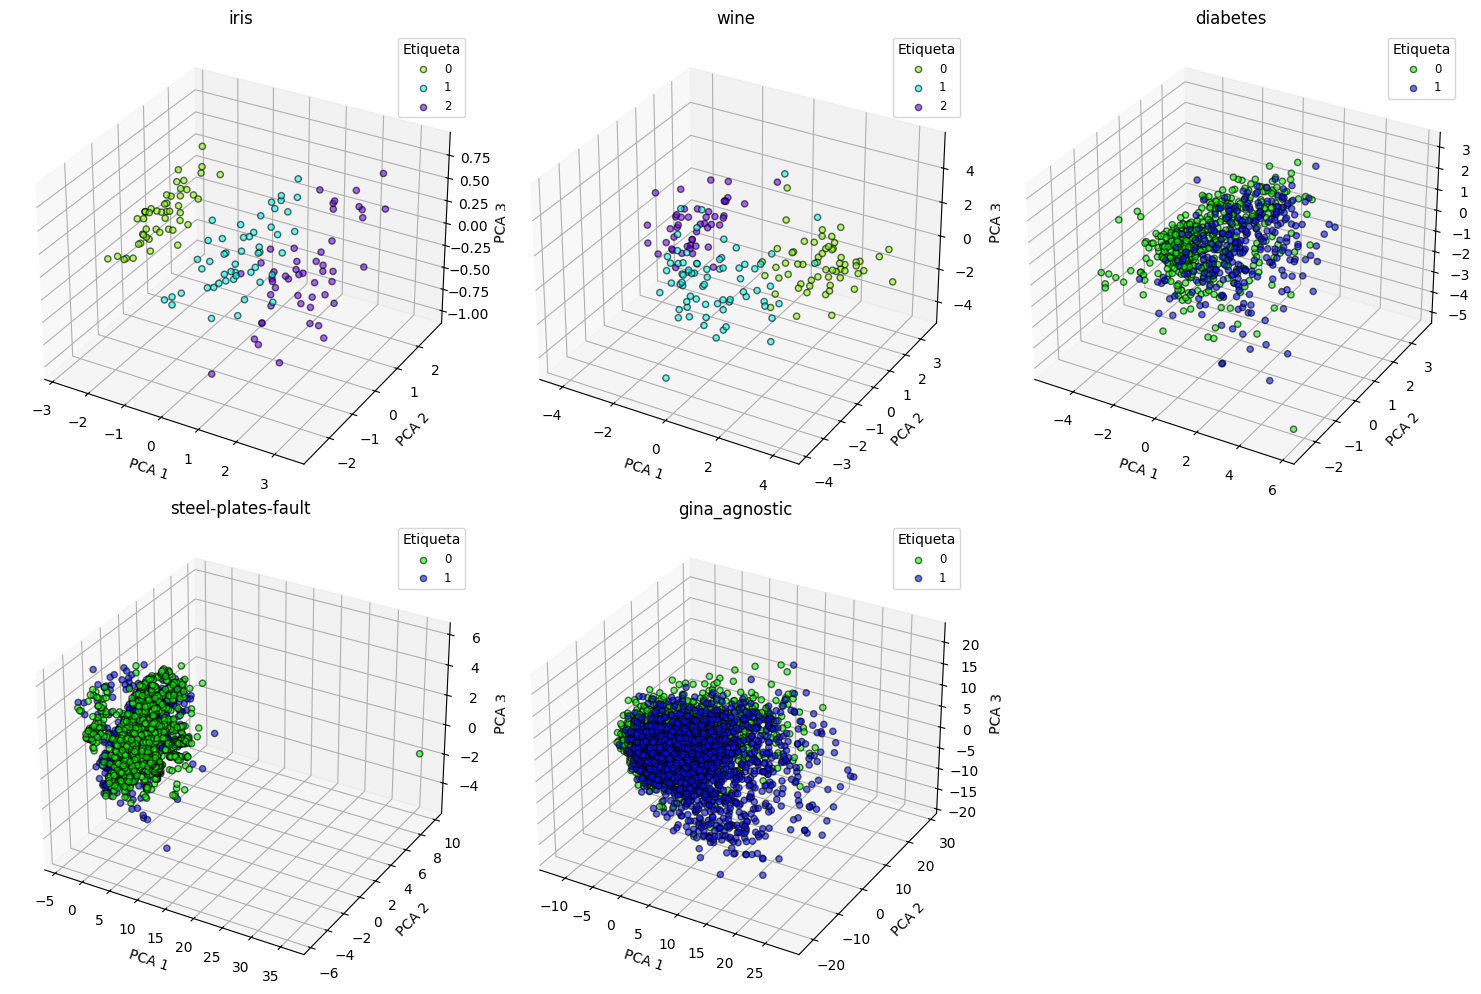

In [9]:
from sklearn.preprocessing import StandardScaler

'''--------- Función para representar los datos en 3D ---------'''
def plot_3d(dataset_name, X_scaled, y):

    # Reducir dimensionalidad a 3 componentes con PCA
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)

    # Colores
    unique_classes = np.unique(y)
    colors = sns.color_palette("hsv", len(unique_classes))
    color_map = dict(zip(unique_classes, colors))

    return dataset_name, X_pca, y, unique_classes, color_map

'''--------- Generar gráficos para cada dataset ---------'''
fig = plt.figure(figsize=(15, 10))
cols = 3
rows = -(-len(scaled_datasets) // cols)

for i, (name, (X_scaled, y)) in enumerate(scaled_datasets.items()):
    dataset_name, X_pca, y, unique_classes, color_map = plot_3d(name, X_scaled, y)
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')

    for label in unique_classes:
        indices = y == label
        ax.scatter(X_pca[indices, 0], X_pca[indices, 1], X_pca[indices, 2],
                   label=label, color=color_map[label], alpha=0.6, edgecolors="k")

    ax.set_title(f'{dataset_name}')
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.set_zlabel('PCA 3')
    ax.legend(title="Etiqueta", fontsize='small')

plt.tight_layout()
plt.show()

Defino una SEED y un RandomState para la reproducibilidad del código.

In [10]:
SEED = 38
RNG = np.random.RandomState(38)

A continuación, obtenemos el conjunto de datos de entrenamiento y prueba separando sus características y etiquetas. Antes divido los atributos X de cada dataset, así como la variable que usaremos como variable dependiente Y en diferentes variables para mayor claridad.

In [11]:
from sklearn.model_selection import train_test_split
'''--------- Dataset Iris ---------'''
Iris_X = scaled_datasets['iris'][0]
Iris_Y = scaled_datasets['iris'][1]
Iris_X_train, Iris_X_test, Iris_Y_train, Iris_Y_test = train_test_split(Iris_X, Iris_Y, test_size=0.3, random_state=SEED)

'''--------- Dataset Wine ---------'''
Wine_X = scaled_datasets['wine'][0]
Wine_Y = scaled_datasets['wine'][1]
Wine_X_train, Wine_X_test, Wine_Y_train, Wine_Y_test = train_test_split(Wine_X, Wine_Y, test_size=0.3, random_state=SEED)

'''--------- Dataset Diabetes ---------'''
Diabetes_X = scaled_datasets['diabetes'][0]
Diabetes_Y = scaled_datasets['diabetes'][1]
Diabetes_X_train, Diabetes_X_test, Diabetes_Y_train, Diabetes_Y_test = train_test_split(Diabetes_X, Diabetes_Y, test_size=0.3, random_state=SEED)

'''--------- Dataset steel-plates-fault ---------'''
steel_plates_fault_X = scaled_datasets['steel-plates-fault'][0]
steel_plates_fault_Y = scaled_datasets['steel-plates-fault'][1]
steel_plates_fault_X_train, steel_plates_fault_X_test, steel_plates_fault_Y_train, steel_plates_fault_Y_test = train_test_split(steel_plates_fault_X, steel_plates_fault_Y, test_size=0.3, random_state=SEED)

'''--------- Dataset gina_agnostic ---------'''
gina_agnostic_X = scaled_datasets['gina_agnostic'][0]
gina_agnostic_Y = scaled_datasets['gina_agnostic'][1]
gina_agnostic_X_train, gina_agnostic_X_test, gina_agnostic_Y_train, gina_agnostic_Y_test = train_test_split(gina_agnostic_X, gina_agnostic_Y, test_size=0.3, random_state=SEED)

Defino la variable que indica el porcetaje de etiquetas que se eliminarán

In [4]:
PORCENTAJE_LABEL_ELIMINADAS = 0.25

In [12]:
import numpy as np

def remove_labels_and_delete_instances(X, y, pct, RNG):
    n_remove = int(len(y) * pct)
    remove_indices = RNG.choice(len(y), size=n_remove, replace=False)

    # Crear la versión semi-supervisada de y con etiquetas eliminadas (-1)
    y_semi = y.copy()
    y_semi[remove_indices] = -1

    # Crear los conjuntos con instancias eliminadas
    X_deleted = np.delete(X, remove_indices, axis=0)
    y_deleted = np.delete(y, remove_indices)

    return y_semi, X_deleted, y_deleted

'''--------- Aplicación de eliminación de etiquetas e instancias ---------'''
# Dataset Iris
Iris_Y_train_semi, Iris_X_deleted, Iris_Y_deleted = remove_labels_and_delete_instances(Iris_X_train, Iris_Y_train, PORCENTAJE_LABEL_ELIMINADAS, RNG)

# Dataset Wine
Wine_Y_train_semi, Wine_X_deleted, Wine_Y_deleted = remove_labels_and_delete_instances(Wine_X_train, Wine_Y_train, PORCENTAJE_LABEL_ELIMINADAS, RNG)

# Dataset Diabetes
Diabetes_Y_train_semi, Diabetes_X_deleted, Diabetes_Y_deleted = remove_labels_and_delete_instances(Diabetes_X_train, Diabetes_Y_train, PORCENTAJE_LABEL_ELIMINADAS, RNG)

# Dataset steel-plates-fault
steel_plates_fault_Y_train_semi, steel_plates_fault_X_deleted, steel_plates_fault_Y_deleted = remove_labels_and_delete_instances(steel_plates_fault_X_train, steel_plates_fault_Y_train, PORCENTAJE_LABEL_ELIMINADAS, RNG)

# Dataset gina_agnostic
gina_agnostic_Y_train_semi, gina_agnostic_X_deleted, gina_agnostic_Y_deleted = remove_labels_and_delete_instances(gina_agnostic_X_train, gina_agnostic_Y_train, PORCENTAJE_LABEL_ELIMINADAS, RNG)

## Entrenamiento modelos

Primero, defino los modelos LabelPropagation, SelfTrainingClassifier y RandomForestClassifier.

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import LabelPropagation, SelfTrainingClassifier
from sklearn.svm import SVC

'''--------- Self Training ---------'''
svc = SVC(probability=True, gamma="auto")
Iris_self_training_model = SelfTrainingClassifier(svc)
Wine_self_training_model = SelfTrainingClassifier(svc)
Diabetes_self_training_model = SelfTrainingClassifier(svc)
steel_plates_fault_self_training_model = SelfTrainingClassifier(svc)
gina_agnostic_self_training_model = SelfTrainingClassifier(svc)

'''--------- Label Propagation ---------'''
Iris_lp = LabelPropagation(kernel='knn')
Wine_lp = LabelPropagation(kernel='knn')
Diabetes_lp = LabelPropagation(kernel='knn')
steel_plates_fault_lp = LabelPropagation(kernel='knn')
gina_agnostic_lp = LabelPropagation(kernel='knn')

'''--------- Random Forest ---------'''
Iris_rf = RandomForestClassifier(random_state=SEED)
Wine_rf = RandomForestClassifier(random_state=SEED)
Diabetes_rf = RandomForestClassifier(random_state=SEED)
steel_plates_fault_rf = RandomForestClassifier(random_state=SEED)
gina_agnostic_rf = RandomForestClassifier(random_state=SEED)

Entreno los modelos con sus correspodientes variables y etiquetas. Uso las Y con valores faltantes para el label propagation y el self training, y los conjuntos de datos con las instancias eliminadas para el random forest.

In [ ]:
'''--------- Dataset Iris ---------'''
Iris_self_training_model.fit(Iris_X_train, Iris_Y_train_semi)
Iris_lp.fit(Iris_X_train, Iris_Y_train_semi)
Iris_rf.fit(Iris_X_deleted, Iris_Y_deleted)

'''--------- Dataset Wine ---------'''
Wine_self_training_model.fit(Wine_X_train, Wine_Y_train_semi)
Wine_lp.fit(Wine_X_train, Wine_Y_train_semi)
Wine_rf.fit(Wine_X_deleted, Wine_Y_deleted)

'''--------- Dataset Diabetes ---------'''
Diabetes_self_training_model.fit(Diabetes_X_train, Diabetes_Y_train_semi)
Diabetes_lp.fit(Diabetes_X_train, Diabetes_Y_train_semi)
Diabetes_rf.fit(Diabetes_X_deleted, Diabetes_Y_deleted)

'''--------- Dataset steel-plates-fault ---------'''
steel_plates_fault_self_training_model.fit(steel_plates_fault_X_train, steel_plates_fault_Y_train_semi)
steel_plates_fault_lp.fit(steel_plates_fault_X_train, steel_plates_fault_Y_train_semi)
steel_plates_fault_rf.fit(steel_plates_fault_X_deleted, steel_plates_fault_Y_deleted)

'''--------- Dataset gina_agnostic ---------'''
gina_agnostic_self_training_model.fit(gina_agnostic_X_train, gina_agnostic_Y_train_semi)
gina_agnostic_lp.fit(gina_agnostic_X_train, gina_agnostic_Y_train_semi)
gina_agnostic_rf.fit(gina_agnostic_X_deleted, gina_agnostic_Y_deleted)

RandomForestClassifier(random_state=38)

## Prueba de modelos

Uso los modelos entrenados con las instancias reselvadas para el test.

In [36]:
'''--------- Dataset Iris ---------'''
Iris_st_predictions = Iris_self_training_model.predict(Iris_X_test)
Iris_lp_predictions = Iris_lp.predict(Iris_X_test)
Iris_rf_predictions = Iris_rf.predict(Iris_X_test)

'''--------- Dataset Wine ---------'''
Wine_st_predictions = Wine_self_training_model.predict(Wine_X_test)
Wine_lp_predictions = Wine_lp.predict(Wine_X_test)
Wine_rf_predictions = Wine_rf.predict(Wine_X_test)

'''--------- Dataset Diabetes ---------'''
Diabetes_st_predictions = Diabetes_self_training_model.predict(Diabetes_X_test)
Diabetes_lp_predictions = Diabetes_lp.predict(Diabetes_X_test)
Diabetes_rf_predictions = Diabetes_rf.predict(Diabetes_X_test)

'''--------- Dataset steel-plates-fault ---------'''
steel_plates_fault_st_predictions = steel_plates_fault_self_training_model.predict(steel_plates_fault_X_test)
steel_plates_fault_lp_predictions = steel_plates_fault_lp.predict(steel_plates_fault_X_test)
steel_plates_fault_rf_predictions = steel_plates_fault_rf.predict(steel_plates_fault_X_test)

'''--------- Dataset gina_agnostic ---------'''
gina_agnostic_st_predictions = gina_agnostic_self_training_model.predict(gina_agnostic_X_test)
gina_agnostic_lp_predictions = gina_agnostic_lp.predict(gina_agnostic_X_test)
gina_agnostic_rf_predictions = gina_agnostic_rf.predict(gina_agnostic_X_test)

## Evaluación de modelos

En este punto, obtendré diferentes métricas: accuracy, precision, recall y f1; para poder evaluar los modelos e interpretar cual ha dado mejores resultados en estos datasets.

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
'''--------- Matrices de Confusión ---------'''
Iris_st_cm = confusion_matrix(Iris_Y_test, Iris_st_predictions)
Iris_lp_cm = confusion_matrix(Iris_Y_test, Iris_lp_predictions)
Iris_rf_cm = confusion_matrix(Iris_Y_test, Iris_rf_predictions)

Wine_st_cm = confusion_matrix(Wine_Y_test, Wine_st_predictions)
Wine_lp_cm = confusion_matrix(Wine_Y_test, Wine_lp_predictions)
Wine_rf_cm = confusion_matrix(Wine_Y_test, Wine_rf_predictions)

Diabetes_st_cm = confusion_matrix(Diabetes_Y_test, Diabetes_st_predictions)
Diabetes_lp_cm = confusion_matrix(Diabetes_Y_test, Diabetes_lp_predictions)
Diabetes_rf_cm = confusion_matrix(Diabetes_Y_test, Diabetes_rf_predictions)

steel_plates_fault_st_cm = confusion_matrix(steel_plates_fault_Y_test, steel_plates_fault_st_predictions)
steel_plates_fault_lp_cm = confusion_matrix(steel_plates_fault_Y_test, steel_plates_fault_lp_predictions)
steel_plates_fault_rf_cm = confusion_matrix(steel_plates_fault_Y_test, steel_plates_fault_rf_predictions)

gina_agnostic_st_cm = confusion_matrix(gina_agnostic_Y_test, gina_agnostic_st_predictions)
gina_agnostic_lp_cm = confusion_matrix(gina_agnostic_Y_test, gina_agnostic_lp_predictions)
gina_agnostic_rf_cm = confusion_matrix(gina_agnostic_Y_test, gina_agnostic_rf_predictions)


'''--------- Accuracy ---------'''
Iris_st_accuracy = accuracy_score(Iris_Y_test, Iris_st_predictions)
Iris_lp_accuracy = accuracy_score(Iris_Y_test, Iris_lp_predictions)
Iris_rf_accuracy = accuracy_score(Iris_Y_test, Iris_rf_predictions)

Wine_st_accuracy = accuracy_score(Wine_Y_test, Wine_st_predictions)
Wine_lp_accuracy = accuracy_score(Wine_Y_test, Wine_lp_predictions)
Wine_rf_accuracy = accuracy_score(Wine_Y_test, Wine_rf_predictions)

Diabetes_st_accuracy = accuracy_score(Diabetes_Y_test, Diabetes_st_predictions)
Diabetes_lp_accuracy = accuracy_score(Diabetes_Y_test, Diabetes_lp_predictions)
Diabetes_rf_accuracy = accuracy_score(Diabetes_Y_test, Diabetes_rf_predictions)

steel_plates_fault_st_accuracy = accuracy_score(steel_plates_fault_Y_test, steel_plates_fault_st_predictions)
steel_plates_fault_lp_accuracy = accuracy_score(steel_plates_fault_Y_test, steel_plates_fault_lp_predictions)
steel_plates_fault_rf_accuracy = accuracy_score(steel_plates_fault_Y_test, steel_plates_fault_rf_predictions)

gina_agnostic_st_accuracy = accuracy_score(gina_agnostic_Y_test, gina_agnostic_st_predictions)
gina_agnostic_lp_accuracy = accuracy_score(gina_agnostic_Y_test, gina_agnostic_lp_predictions)
gina_agnostic_rf_accuracy = accuracy_score(gina_agnostic_Y_test, gina_agnostic_rf_predictions)


'''--------- Precision ---------'''
Iris_st_precision = precision_score(Iris_Y_test, Iris_st_predictions, average='weighted')
Iris_lp_precision = precision_score(Iris_Y_test, Iris_lp_predictions, average='weighted')
Iris_rf_precision = precision_score(Iris_Y_test, Iris_rf_predictions, average='weighted')

Wine_st_precision = precision_score(Wine_Y_test, Wine_st_predictions, average='weighted')
Wine_lp_precision = precision_score(Wine_Y_test, Wine_lp_predictions, average='weighted')
Wine_rf_precision = precision_score(Wine_Y_test, Wine_rf_predictions, average='weighted')

Diabetes_st_precision = precision_score(Diabetes_Y_test, Diabetes_st_predictions, average='weighted')
Diabetes_lp_precision = precision_score(Diabetes_Y_test, Diabetes_lp_predictions, average='weighted')
Diabetes_rf_precision = precision_score(Diabetes_Y_test, Diabetes_rf_predictions, average='weighted')

steel_plates_fault_st_precision = precision_score(steel_plates_fault_Y_test, steel_plates_fault_st_predictions, average='weighted')
steel_plates_fault_lp_precision = precision_score(steel_plates_fault_Y_test, steel_plates_fault_lp_predictions, average='weighted')
steel_plates_fault_rf_precision = precision_score(steel_plates_fault_Y_test, steel_plates_fault_rf_predictions, average='weighted')

gina_agnostic_st_precision = precision_score(gina_agnostic_Y_test, gina_agnostic_st_predictions, average='weighted')
gina_agnostic_lp_precision = precision_score(gina_agnostic_Y_test, gina_agnostic_lp_predictions, average='weighted')
gina_agnostic_rf_precision = precision_score(gina_agnostic_Y_test, gina_agnostic_rf_predictions, average='weighted')


'''--------- Recall ---------'''
Iris_st_recall = recall_score(Iris_Y_test, Iris_st_predictions, average='weighted')
Iris_lp_recall = recall_score(Iris_Y_test, Iris_lp_predictions, average='weighted')
Iris_rf_recall = recall_score(Iris_Y_test, Iris_rf_predictions, average='weighted')

Wine_st_recall = recall_score(Wine_Y_test, Wine_st_predictions, average='weighted')
Wine_lp_recall = recall_score(Wine_Y_test, Wine_lp_predictions, average='weighted')
Wine_rf_recall = recall_score(Wine_Y_test, Wine_rf_predictions, average='weighted')

Diabetes_st_recall = recall_score(Diabetes_Y_test, Diabetes_st_predictions, average='weighted')
Diabetes_lp_recall = recall_score(Diabetes_Y_test, Diabetes_lp_predictions, average='weighted')
Diabetes_rf_recall = recall_score(Diabetes_Y_test, Diabetes_rf_predictions, average='weighted')

steel_plates_fault_st_recall = recall_score(steel_plates_fault_Y_test, steel_plates_fault_st_predictions, average='weighted')
steel_plates_fault_lp_recall = recall_score(steel_plates_fault_Y_test, steel_plates_fault_lp_predictions, average='weighted')
steel_plates_fault_rf_recall = recall_score(steel_plates_fault_Y_test, steel_plates_fault_rf_predictions, average='weighted')

gina_agnostic_st_recall = recall_score(gina_agnostic_Y_test, gina_agnostic_st_predictions, average='weighted')
gina_agnostic_lp_recall = recall_score(gina_agnostic_Y_test, gina_agnostic_lp_predictions, average='weighted')
gina_agnostic_rf_recall = recall_score(gina_agnostic_Y_test, gina_agnostic_rf_predictions, average='weighted')

'''--------- F1 Score ---------'''
Iris_st_f1 = f1_score(Iris_Y_test, Iris_st_predictions, average='weighted')
Iris_lp_f1 = f1_score(Iris_Y_test, Iris_lp_predictions, average='weighted')
Iris_rf_f1 = f1_score(Iris_Y_test, Iris_rf_predictions, average='weighted')

Wine_st_f1 = f1_score(Wine_Y_test, Wine_st_predictions, average='weighted')
Wine_lp_f1 = f1_score(Wine_Y_test, Wine_lp_predictions, average='weighted')
Wine_rf_f1 = f1_score(Wine_Y_test, Wine_rf_predictions, average='weighted')

Diabetes_st_f1 = f1_score(Diabetes_Y_test, Diabetes_st_predictions, average='weighted')
Diabetes_lp_f1 = f1_score(Diabetes_Y_test, Diabetes_lp_predictions, average='weighted')
Diabetes_rf_f1 = f1_score(Diabetes_Y_test, Diabetes_rf_predictions, average='weighted')

steel_plates_fault_st_f1 = f1_score(steel_plates_fault_Y_test, steel_plates_fault_st_predictions, average='weighted')
steel_plates_fault_lp_f1 = f1_score(steel_plates_fault_Y_test, steel_plates_fault_lp_predictions, average='weighted')
steel_plates_fault_rf_f1 = f1_score(steel_plates_fault_Y_test, steel_plates_fault_rf_predictions, average='weighted')

gina_agnostic_st_f1 = f1_score(gina_agnostic_Y_test, gina_agnostic_st_predictions, average='weighted')
gina_agnostic_lp_f1 = f1_score(gina_agnostic_Y_test, gina_agnostic_lp_predictions, average='weighted')
gina_agnostic_rf_f1 = f1_score(gina_agnostic_Y_test, gina_agnostic_rf_predictions, average='weighted')

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def print_metrics(dataset_name, algorithm_name, cm, accuracy, precision, recall, f1, fig, ax):
    print(f"{algorithm_name} con dataset {dataset_name}:")
    print(f"-  Accuracy: {accuracy:.4f}")
    print(f"-  Precisión: {precision:.4f}")
    print(f"-  Recall: {recall:.4f}")
    print(f"-  F1 Score: {f1:.4f}")
    print("\n")

    # Visualización de la matriz de confusión usando ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax)
    ax.set_title(f"{dataset_name} - {algorithm_name}")

Self Training con dataset Iris:
-  Accuracy: 0.9778
-  Precisión: 0.9792
-  Recall: 0.9778
-  F1 Score: 0.9777


Label Propagation con dataset Iris:
-  Accuracy: 0.9556
-  Precisión: 0.9608
-  Recall: 0.9556
-  F1 Score: 0.9551


Random Forest con dataset Iris:
-  Accuracy: 0.9556
-  Precisión: 0.9608
-  Recall: 0.9556
-  F1 Score: 0.9551


Self Training con dataset Wine:
-  Accuracy: 0.9815
-  Precisión: 0.9824
-  Recall: 0.9815
-  F1 Score: 0.9814


Label Propagation con dataset Wine:
-  Accuracy: 0.9630
-  Precisión: 0.9665
-  Recall: 0.9630
-  F1 Score: 0.9629


Random Forest con dataset Wine:
-  Accuracy: 0.9815
-  Precisión: 0.9824
-  Recall: 0.9815
-  F1 Score: 0.9815


Self Training con dataset Diabetes:
-  Accuracy: 0.7619
-  Precisión: 0.7596
-  Recall: 0.7619
-  F1 Score: 0.7504


Label Propagation con dataset Diabetes:
-  Accuracy: 0.6970
-  Precisión: 0.6877
-  Recall: 0.6970
-  F1 Score: 0.6888


Random Forest con dataset Diabetes:
-  Accuracy: 0.7489
-  Precisión: 0.7432

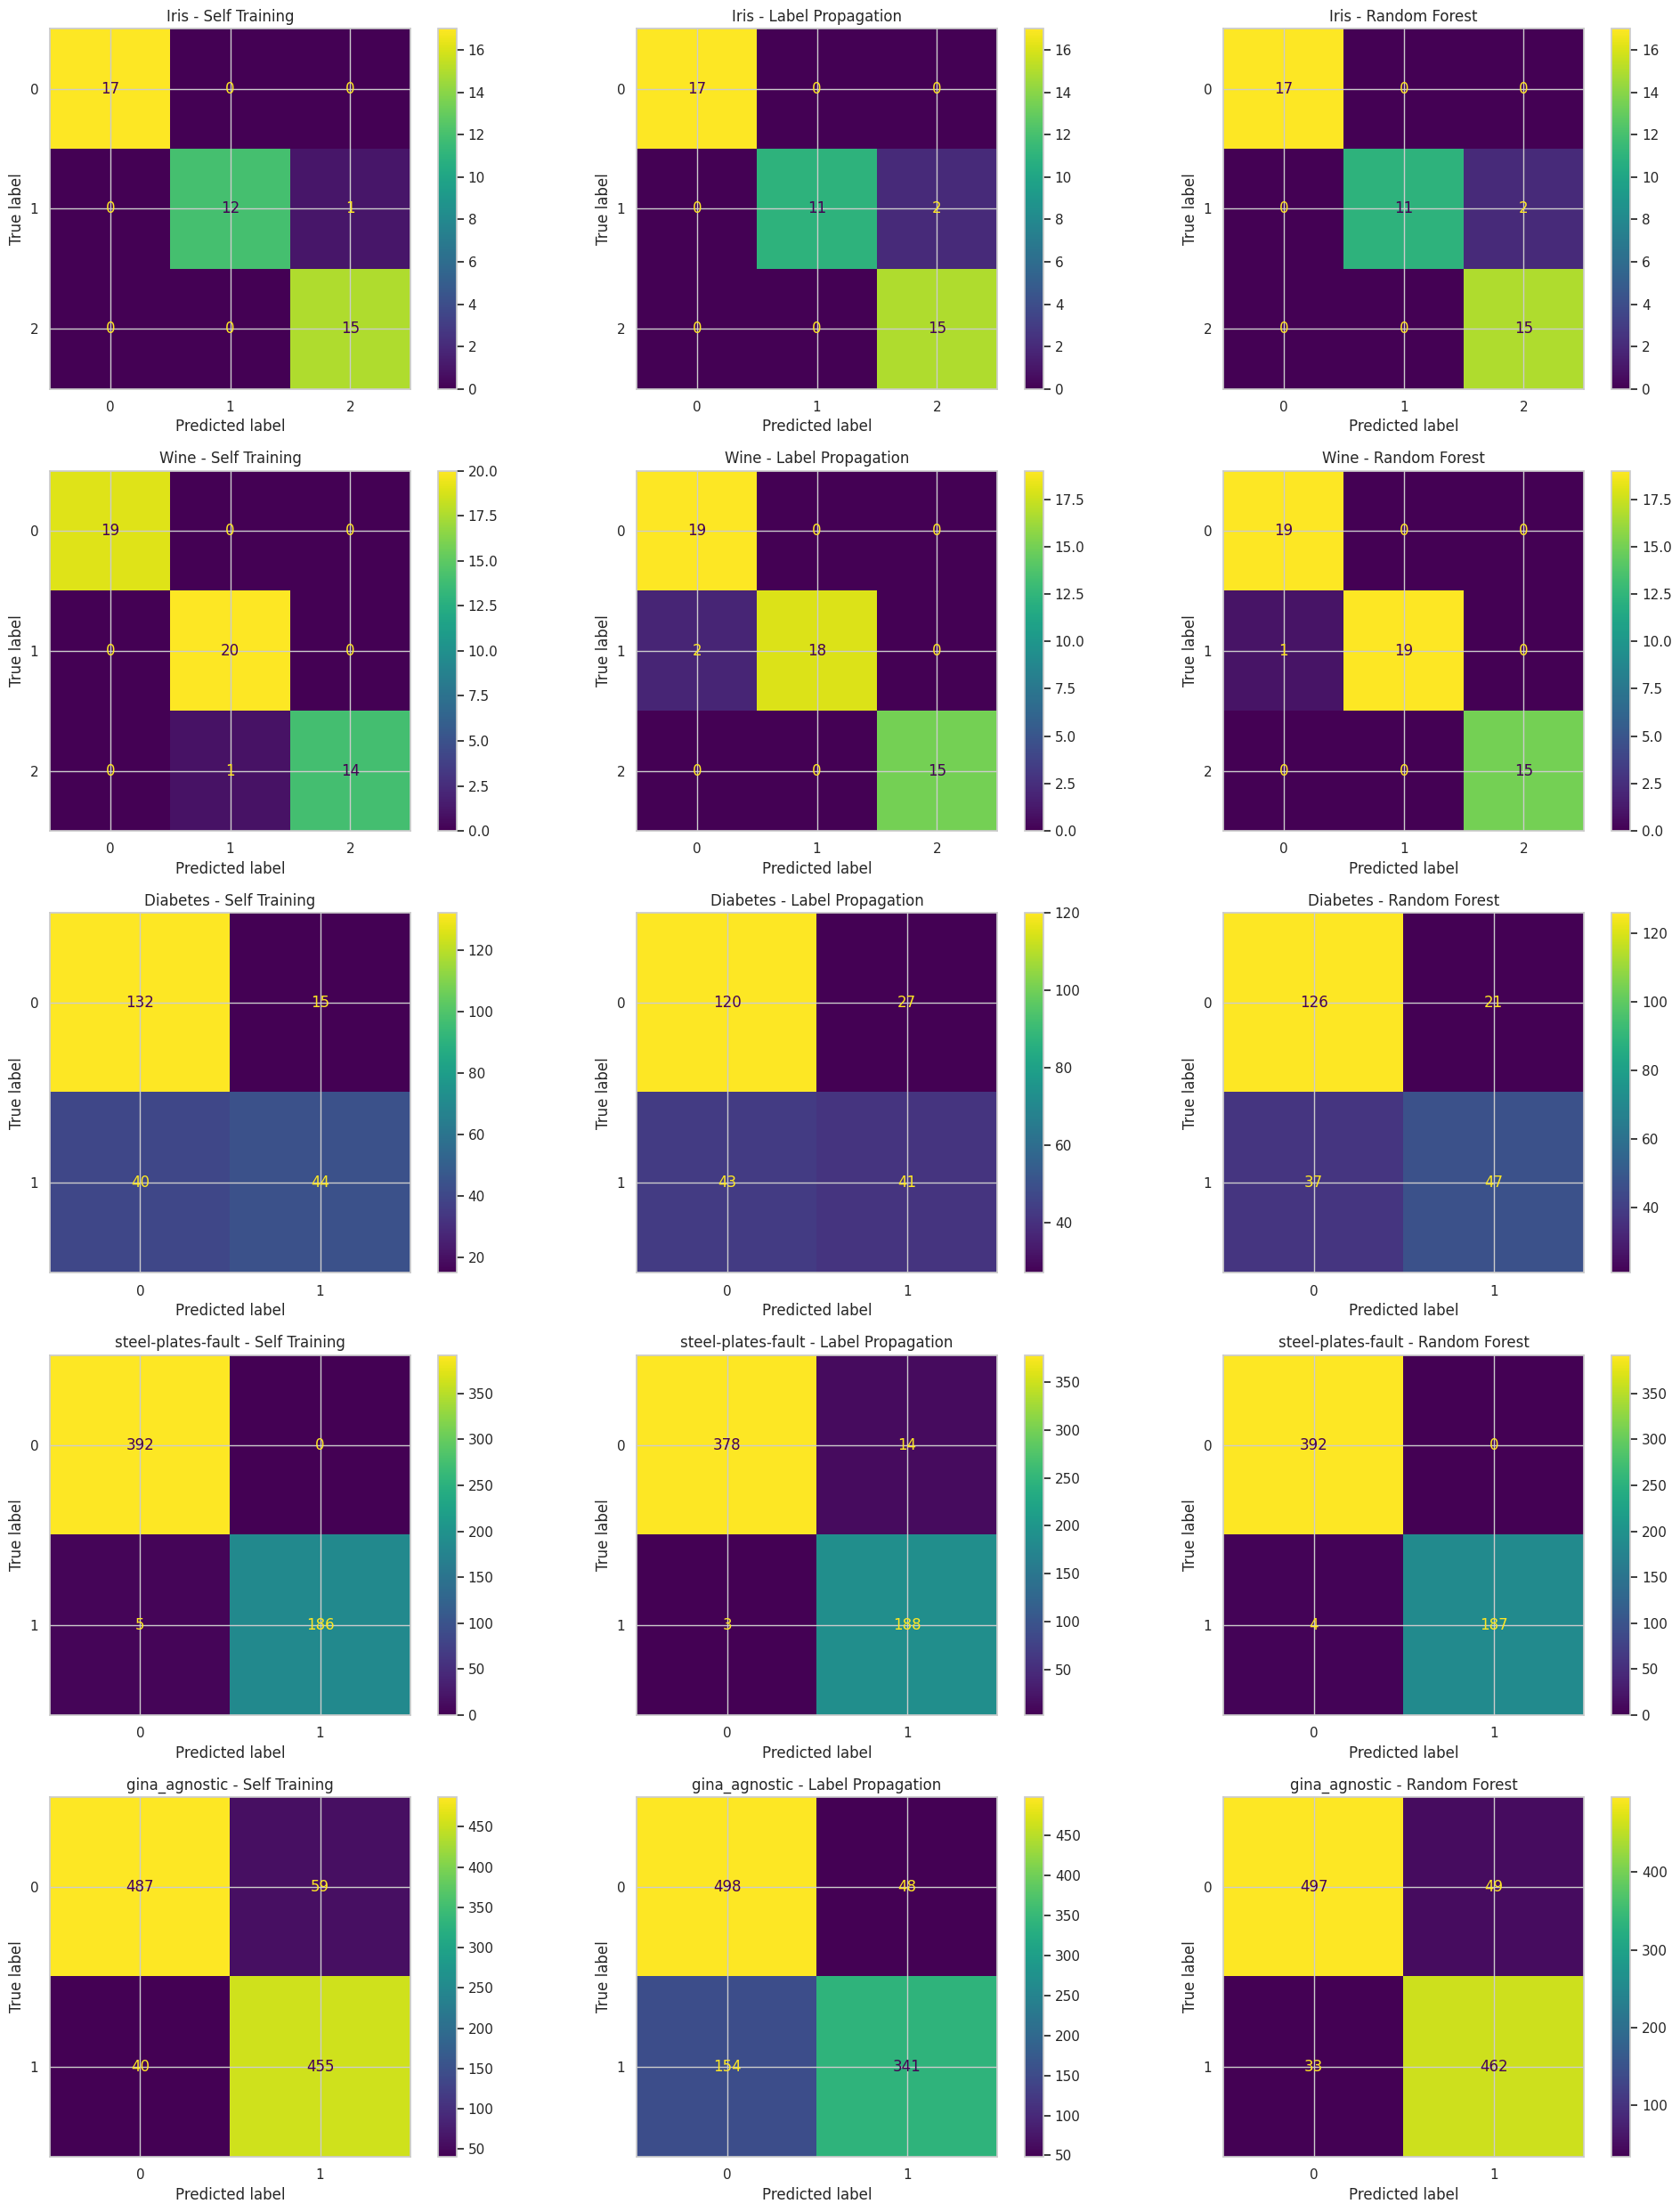

In [39]:
# Crear una figura y ejes para las subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 25)) # 5 datasets * 3 algorithms

'''--------- Métricas Iris dataset ---------'''
print_metrics("Iris", "Self Training", Iris_st_cm, Iris_st_accuracy, Iris_st_precision, Iris_st_recall, Iris_st_f1, fig, axes[0, 0])
print_metrics("Iris", "Label Propagation", Iris_lp_cm, Iris_lp_accuracy, Iris_lp_precision, Iris_lp_recall, Iris_lp_f1, fig, axes[0, 1])
print_metrics("Iris", "Random Forest", Iris_rf_cm, Iris_rf_accuracy, Iris_rf_precision, Iris_rf_recall, Iris_rf_f1, fig, axes[0, 2])

'''--------- Métricas Wine dataset ---------'''
print_metrics("Wine", "Self Training", Wine_st_cm, Wine_st_accuracy, Wine_st_precision, Wine_st_recall, Wine_st_f1, fig, axes[1, 0])
print_metrics("Wine", "Label Propagation", Wine_lp_cm, Wine_lp_accuracy, Wine_lp_precision, Wine_lp_recall, Wine_lp_f1, fig, axes[1, 1])
print_metrics("Wine", "Random Forest", Wine_rf_cm, Wine_rf_accuracy, Wine_rf_precision, Wine_rf_recall, Wine_rf_f1, fig, axes[1, 2])

'''--------- Métricas Diabetes dataset ---------'''
print_metrics("Diabetes", "Self Training", Diabetes_st_cm, Diabetes_st_accuracy, Diabetes_st_precision, Diabetes_st_recall, Diabetes_st_f1, fig, axes[2, 0])
print_metrics("Diabetes", "Label Propagation", Diabetes_lp_cm, Diabetes_lp_accuracy, Diabetes_lp_precision, Diabetes_lp_recall, Diabetes_lp_f1, fig, axes[2, 1])
print_metrics("Diabetes", "Random Forest", Diabetes_rf_cm, Diabetes_rf_accuracy, Diabetes_rf_precision, Diabetes_rf_recall, Diabetes_rf_f1, fig, axes[2, 2])

'''--------- Métricas steel-plates-fault dataset ---------'''
print_metrics("steel-plates-fault", "Self Training", steel_plates_fault_st_cm, steel_plates_fault_st_accuracy, steel_plates_fault_st_precision, steel_plates_fault_st_recall, steel_plates_fault_st_f1, fig, axes[3, 0])
print_metrics("steel-plates-fault", "Label Propagation", steel_plates_fault_lp_cm, steel_plates_fault_lp_accuracy, steel_plates_fault_lp_precision, steel_plates_fault_lp_recall, steel_plates_fault_lp_f1, fig, axes[3, 1])
print_metrics("steel-plates-fault", "Random Forest", steel_plates_fault_rf_cm, steel_plates_fault_rf_accuracy, steel_plates_fault_rf_precision, steel_plates_fault_rf_recall, steel_plates_fault_rf_f1, fig, axes[3, 2])

'''--------- Métricas gina_agnostic dataset ---------'''
print_metrics("gina_agnostic", "Self Training", gina_agnostic_st_cm, gina_agnostic_st_accuracy, gina_agnostic_st_precision, gina_agnostic_st_recall, gina_agnostic_st_f1, fig, axes[4, 0])
print_metrics("gina_agnostic", "Label Propagation", gina_agnostic_lp_cm, gina_agnostic_lp_accuracy, gina_agnostic_lp_precision, gina_agnostic_lp_recall, gina_agnostic_lp_f1, fig, axes[4, 1])
print_metrics("gina_agnostic", "Random Forest", gina_agnostic_rf_cm, gina_agnostic_rf_accuracy, gina_agnostic_rf_precision, gina_agnostic_rf_recall, gina_agnostic_rf_f1, fig, axes[4, 2])

plt.tight_layout()
plt.show()

Con el siguiente código obtengo las métricas en gráficas de barras para interpretar los resultados de forma más visual y sencilla.

<ipython-input-40-97368a1c7b14>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
<ipython-input-40-97368a1c7b14>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
<ipython-input-40-97368a1c7b14>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
<ipython-input-40-97368a1c7b14>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


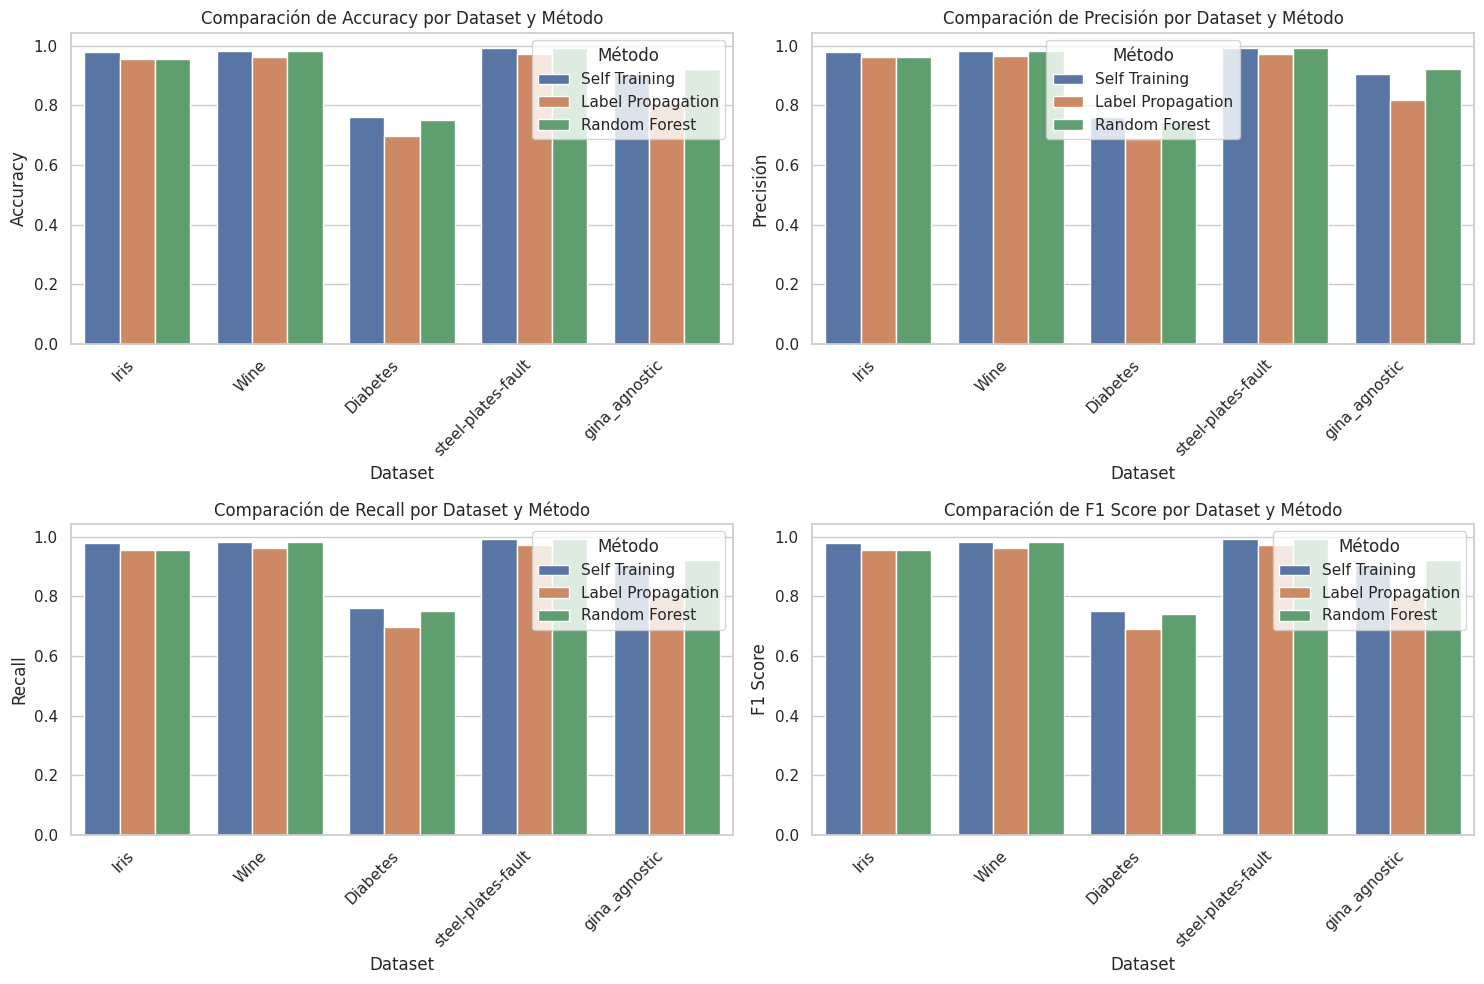

In [40]:
import seaborn as sns
import pandas as pd
# Lista para almacenar resultados
results = []

def store_metrics(dataset_name, algorithm_name, cm, accuracy, precision, recall, f1):
    results.append({
        "Dataset": dataset_name,
        "Método": algorithm_name,
        "Accuracy": accuracy,
        "Precisión": precision,
        "Recall": recall,
        "F1 Score": f1
    })

'''--------- Almacenar métricas en la lista ---------'''

store_metrics("Iris", "Self Training", Iris_st_cm, Iris_st_accuracy, Iris_st_precision, Iris_st_recall, Iris_st_f1)
store_metrics("Iris", "Label Propagation", Iris_lp_cm, Iris_lp_accuracy, Iris_lp_precision, Iris_lp_recall, Iris_lp_f1)
store_metrics("Iris", "Random Forest", Iris_rf_cm, Iris_rf_accuracy, Iris_rf_precision, Iris_rf_recall, Iris_rf_f1)

store_metrics("Wine", "Self Training", Wine_st_cm, Wine_st_accuracy, Wine_st_precision, Wine_st_recall, Wine_st_f1)
store_metrics("Wine", "Label Propagation", Wine_lp_cm, Wine_lp_accuracy, Wine_lp_precision, Wine_lp_recall, Wine_lp_f1)
store_metrics("Wine", "Random Forest", Wine_rf_cm, Wine_rf_accuracy, Wine_rf_precision, Wine_rf_recall, Wine_rf_f1)

store_metrics("Diabetes", "Self Training", Diabetes_st_cm, Diabetes_st_accuracy, Diabetes_st_precision, Diabetes_st_recall, Diabetes_st_f1)
store_metrics("Diabetes", "Label Propagation", Diabetes_lp_cm, Diabetes_lp_accuracy, Diabetes_lp_precision, Diabetes_lp_recall, Diabetes_lp_f1)
store_metrics("Diabetes", "Random Forest", Diabetes_rf_cm, Diabetes_rf_accuracy, Diabetes_rf_precision, Diabetes_rf_recall, Diabetes_rf_f1)

store_metrics("steel-plates-fault", "Self Training", steel_plates_fault_st_cm, steel_plates_fault_st_accuracy, steel_plates_fault_st_precision, steel_plates_fault_st_recall, steel_plates_fault_st_f1)
store_metrics("steel-plates-fault", "Label Propagation", steel_plates_fault_lp_cm, steel_plates_fault_lp_accuracy, steel_plates_fault_lp_precision, steel_plates_fault_lp_recall, steel_plates_fault_lp_f1)
store_metrics("steel-plates-fault", "Random Forest", steel_plates_fault_rf_cm, steel_plates_fault_rf_accuracy, steel_plates_fault_rf_precision, steel_plates_fault_rf_recall, steel_plates_fault_rf_f1)

store_metrics("gina_agnostic", "Self Training", gina_agnostic_st_cm, gina_agnostic_st_accuracy, gina_agnostic_st_precision, gina_agnostic_st_recall, gina_agnostic_st_f1)
store_metrics("gina_agnostic", "Label Propagation", gina_agnostic_lp_cm, gina_agnostic_lp_accuracy, gina_agnostic_lp_precision, gina_agnostic_lp_recall, gina_agnostic_lp_f1)
store_metrics("gina_agnostic", "Random Forest", gina_agnostic_rf_cm, gina_agnostic_rf_accuracy, gina_agnostic_rf_precision, gina_agnostic_rf_recall, gina_agnostic_rf_f1)

df = pd.DataFrame(results)

sns.set(style="whitegrid")

# Crear una figura con subgráficos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ["Accuracy", "Precisión", "Recall", "F1 Score"]

for ax, metric in zip(axes.flat, metrics):
    sns.barplot(data=df, x="Dataset", y=metric, hue="Método", ax=ax)
    ax.set_title(f"Comparación de {metric} por Dataset y Método")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


## Interpretación resultados

### 90% Etiquetas eliminadas

En primer lugar, he eliminado un 90% de las etiquetas. En este caso es cuando mayor rendimiento deberían mostrar los métodos de aprendizaje semi-supervisados en comparación a métodos supervisados, los cuales habrían sido entrenado con bastantes pocas instancias.

*   **Iris**: Label Propagation y Random Forest tienen un rendimiento idéntico para todas las métricas obtenidas, ya que han predicido erróneamente la misma cantidad de veces la misma clase como podemos observar en sus matrices de confusión. En este caso el self training presenta peores resultados.

*   **Wine**: Label Propagation muestra una clara superioridad con un rendimiento significativamente mejor en comparación con Self Training y Random Forest. Self Training por su parte también es ligeramente mejor que Random Forest para este caso. En este dataset resalta la ventaja de los métodos semi-supervisados notablemente.

*   **Diabetes**: Aquí, Random Forest sobresale ligeramente en comparación con los métodos semi-supervisados, lo que puede indicar que el modelo supervisado es más adecuado para este conjunto de datos en particular. Label Propagation, que había tenido un rendimiento muy bueno en los anteriores datasets, en esta caso es el peor modelo, es decir, Label Propagation no es nada adecuado para el dataset Diabetes.

*   **Steel Plates Fault**: Para este conjunto de datos se vuelve a dislumbrar la superioridad de métodos semi-supervisados para datasets con muchas etiquetas faltantes. Self Training ofrece un excelente rendimiento, con resultados muy cercanos a 1 en todas las métricas. Label Propagation sigue siendo competitivo, pero Random Forest tiene un rendimiento notablemente más bajo en comparación.

*   **Gina Agnostic**: Label Propagation tiene una accuracy muy baja (0.5735) y una precisión mediocre de 0.7476, la precision es algo mejor pues los errores son cometidos al predecir la clase negativa como podemos observar en la matriz de confusión. Random Forest en este caso es el mejor modelo, superando tanto a Self Training como a Label Propagation. Esto podría sugerir que con pocas instancias ya podríamos tener suficiente información para clasificar correctamente. Entonces un clasificador supervisado convencional sería más adecuado que realizar un aprendizaje semi-supervisado.

<table border="1">
    <tr>
        <th>Método</th>
        <th>Dataset</th>
        <th>Accuracy</th>
        <th>Precisión</th>
        <th>Recall</th>
        <th>F1 Score</th>
    </tr>
    <tr><td>Self Training</td><td>Iris</td><td>0.8444</td><td>0.8542</td><td>0.8444</td><td>0.8438</td></tr>
    <tr><td>Label Propagation</td><td>Iris</td><td>0.8889</td><td>0.9198</td><td>0.8889</td><td>0.8867</td></tr>
    <tr><td>Random Forest</td><td>Iris</td><td>0.8889</td><td>0.9198</td><td>0.8889</td><td>0.8867</td></tr>
    <tr><td>Self Training</td><td>Wine</td><td>0.7963</td><td>0.8686</td><td>0.7963</td><td>0.7815</td></tr>
    <tr><td>Label Propagation</td><td>Wine</td><td>0.9444</td><td>0.9470</td><td>0.9444</td><td>0.9443</td></tr>
    <tr><td>Random Forest</td><td>Wine</td><td>0.7222</td><td>0.8413</td><td>0.7222</td><td>0.7057</td></tr>
    <tr><td>Self Training</td><td>Diabetes</td><td>0.7013</td><td>0.7121</td><td>0.7013</td><td>0.6553</td></tr>
    <tr><td>Label Propagation</td><td>Diabetes</td><td>0.6494</td><td>0.6260</td><td>0.6494</td><td>0.5751</td></tr>
    <tr><td>Random Forest</td><td>Diabetes</td><td>0.7489</td><td>0.7624</td><td>0.7489</td><td>0.7228</td></tr>
    <tr><td>Self Training</td><td>steel-plates-fault</td><td>0.9708</td><td>0.9714</td><td>0.9708</td><td>0.9706</td></tr>
    <tr><td>Label Propagation</td><td>steel-plates-fault</td><td>0.9348</td><td>0.9350</td><td>0.9348</td><td>0.9349</td></tr>
    <tr><td>Random Forest</td><td>steel-plates-fault</td><td>0.8491</td><td>0.8531</td><td>0.8491</td><td>0.8411</td></tr>
    <tr><td>Self Training</td><td>gina_agnostic</td><td>0.8377</td><td>0.8393</td><td>0.8377</td><td>0.8377</td></tr>
    <tr><td>Label Propagation</td><td>gina_agnostic</td><td>0.5735</td><td>0.7476</td><td>0.5735</td><td>0.4641</td></tr>
    <tr><td>Random Forest</td><td>gina_agnostic</td><td>0.8598</td><td>0.8699</td><td>0.8598</td><td>0.8594</td></tr>
</table>

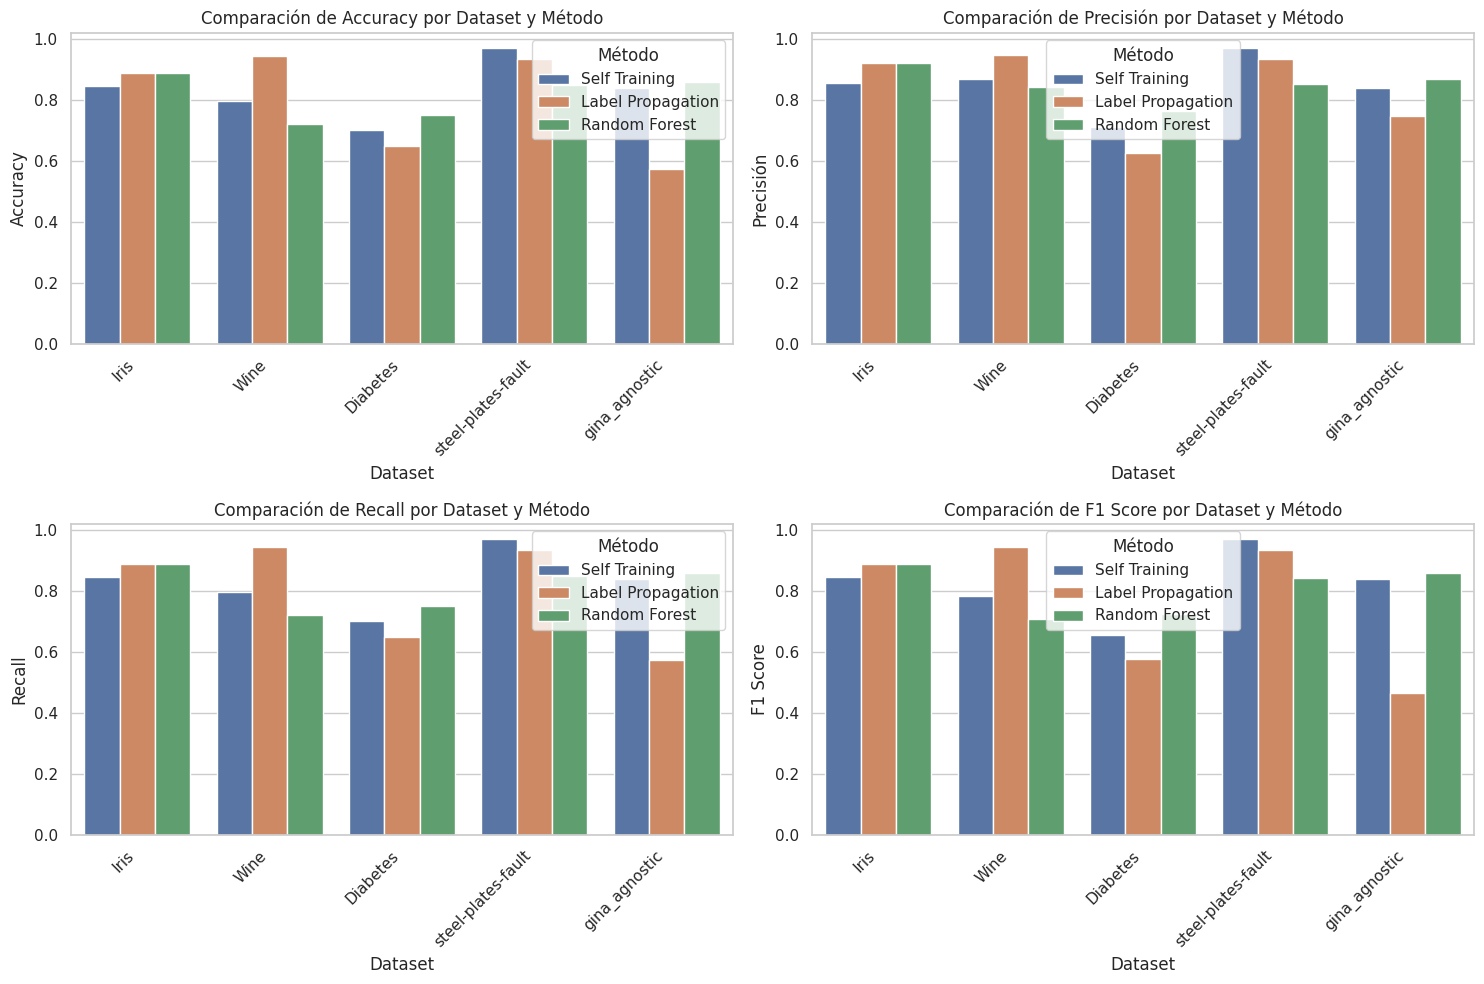

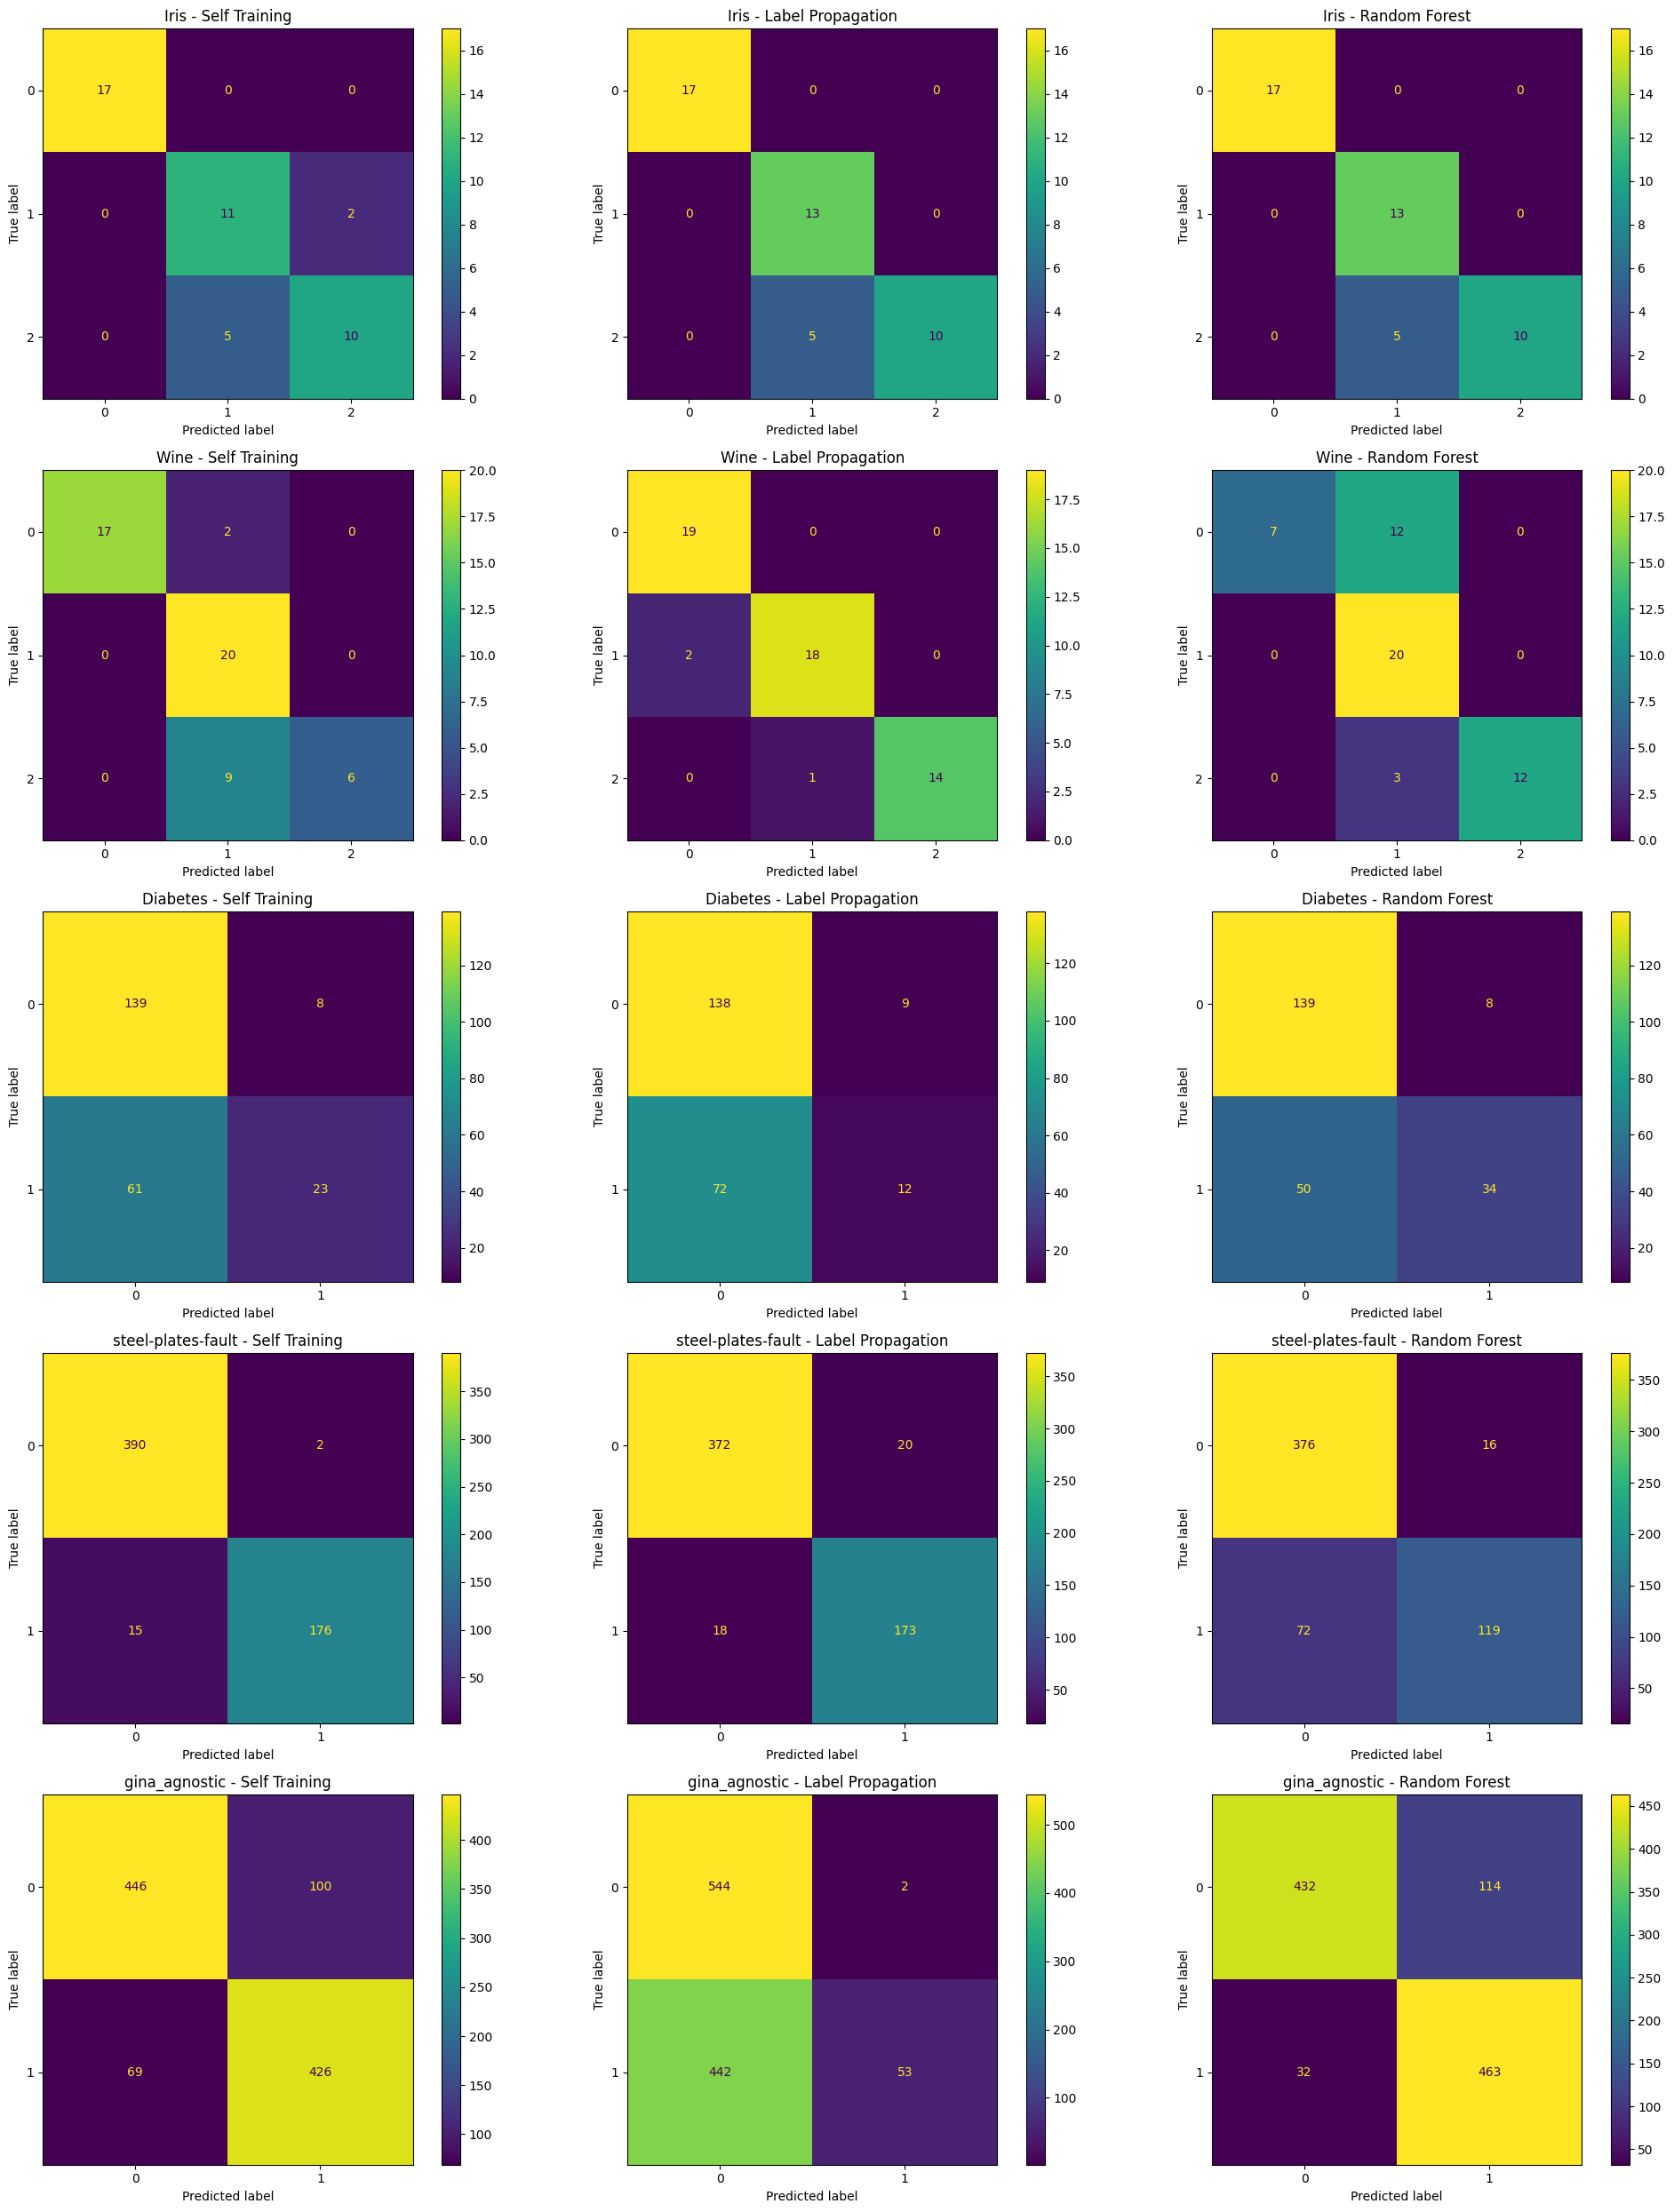

### 50% Etiquetas eliminadas

En este caso, he eliminado el 50% de las etiquetas. A priori, al haber más datos etiquetados, el Random Forest debería beneficiarse.

*   **Iris**: En este dataset, los tres métodos han obtenido exactamente el mismo rendimiento en todas las métricas. Esto indica que el dataset es muy simple.

*   **Wine**: Aquí se observa un rendimiento excelente para Self Training y Random Forest, ambos con valores idénticos en todas las métricas. Label Propagation, aunque sigue mostrando buenos resultados, tiene un rendimiento ligeramente inferior. Este caso es especialmente curioso, pues para un 90% de las etiquetas eliminadas Label Propagation era el mejor clasificador con diferencia.

*   **Diabetes**: Random Forest destaca, superando tanto a Self Training como a Label Propagation que presentan los mismos resultados. Esto confirma la tendencia observada para el 90% de etiquetas eliminadas, donde Random Forest también se imponía en este conjunto de datos. Aunque igualmente tampoco presenta bueno resultados, teniendo todas sus métricas en torno a un 0,7.

*   **Steel Plates Fault**: Self Training ofrece un rendimiento prácticamente perfecto con métricas cercanas a 1. Random Forest también obtiene resultados excelentes, mientras que Label Propagation, aunque competitivo, tiene una pequeña caída en rendimiento. En comparación con el anterior experimento, ahora el Random Forest sí es competitivo, mientras que antes era el peor clasificador con diferencia. En conclusión, para este dataset es importante tener un buen número de instancias correctamente etiquetadas para que un clasificador supervisado pueda funcionar bien.

*   **Gina Agnostic**: Random Forest es el mejor modelo con una accuracy de 0.9174. Self Training se mantiene competitivo, mientras que Label Propagation tiene un rendimiento inferior. Como vimos anteriormente, el uso de un clasificador semi-supervisado no supone un mejora para este dataset.

<table border="1">
    <tr>
        <th>Método</th>
        <th>Dataset</th>
        <th>Accuracy</th>
        <th>Precisión</th>
        <th>Recall</th>
        <th>F1 Score</th>
    </tr>
    <tr><td>Self Training</td><td>Iris</td><td>0.9556</td><td>0.9608</td><td>0.9556</td><td>0.9551</td></tr>
    <tr><td>Label Propagation</td><td>Iris</td><td>0.9556</td><td>0.9608</td><td>0.9556</td><td>0.9551</td></tr>
    <tr><td>Random Forest</td><td>Iris</td><td>0.9556</td><td>0.9608</td><td>0.9556</td><td>0.9551</td></tr>
    <tr><td>Self Training</td><td>Wine</td><td>0.9815</td><td>0.9824</td><td>0.9815</td><td>0.9814</td></tr>
    <tr><td>Label Propagation</td><td>Wine</td><td>0.9630</td><td>0.9665</td><td>0.9630</td><td>0.9629</td></tr>
    <tr><td>Random Forest</td><td>Wine</td><td>0.9815</td><td>0.9824</td><td>0.9815</td><td>0.9815</td></tr>
    <tr><td>Self Training</td><td>Diabetes</td><td>0.7100</td><td>0.7008</td><td>0.7100</td><td>0.6927</td></tr>
    <tr><td>Label Propagation</td><td>Diabetes</td><td>0.7100</td><td>0.7020</td><td>0.7100</td><td>0.6891</td></tr>
    <tr><td>Random Forest</td><td>Diabetes</td><td>0.7446</td><td>0.7388</td><td>0.7446</td><td>0.7349</td></tr>
    <tr><td>Self Training</td><td>steel-plates-fault</td><td>0.9931</td><td>0.9932</td><td>0.9931</td><td>0.9931</td></tr>
    <tr><td>Label Propagation</td><td>steel-plates-fault</td><td>0.9640</td><td>0.9652</td><td>0.9640</td><td>0.9642</td></tr>
    <tr><td>Random Forest</td><td>steel-plates-fault</td><td>0.9708</td><td>0.9709</td><td>0.9708</td><td>0.9707</td></tr>
    <tr><td>Self Training</td><td>gina_agnostic</td><td>0.8991</td><td>0.9000</td><td>0.8991</td><td>0.8992</td></tr>
    <tr><td>Label Propagation</td><td>gina_agnostic</td><td>0.7800</td><td>0.7997</td><td>0.7800</td><td>0.7743</td></tr>
    <tr><td>Random Forest</td><td>gina_agnostic</td><td>0.9174</td><td>0.9183</td><td>0.9174</td><td>0.9174</td></tr>
</table>


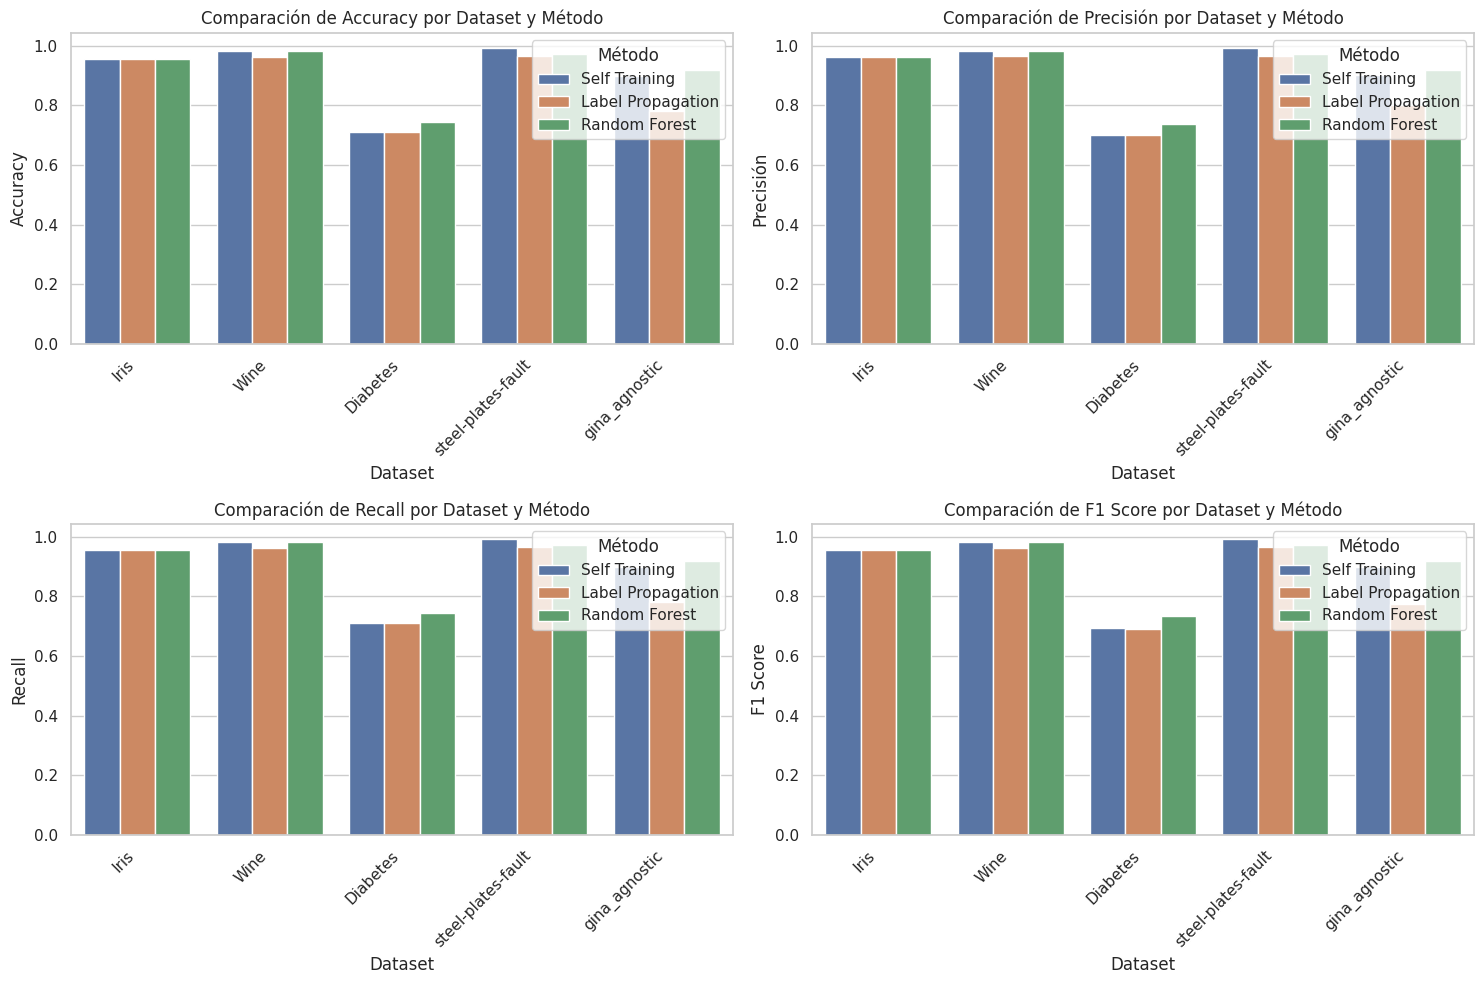

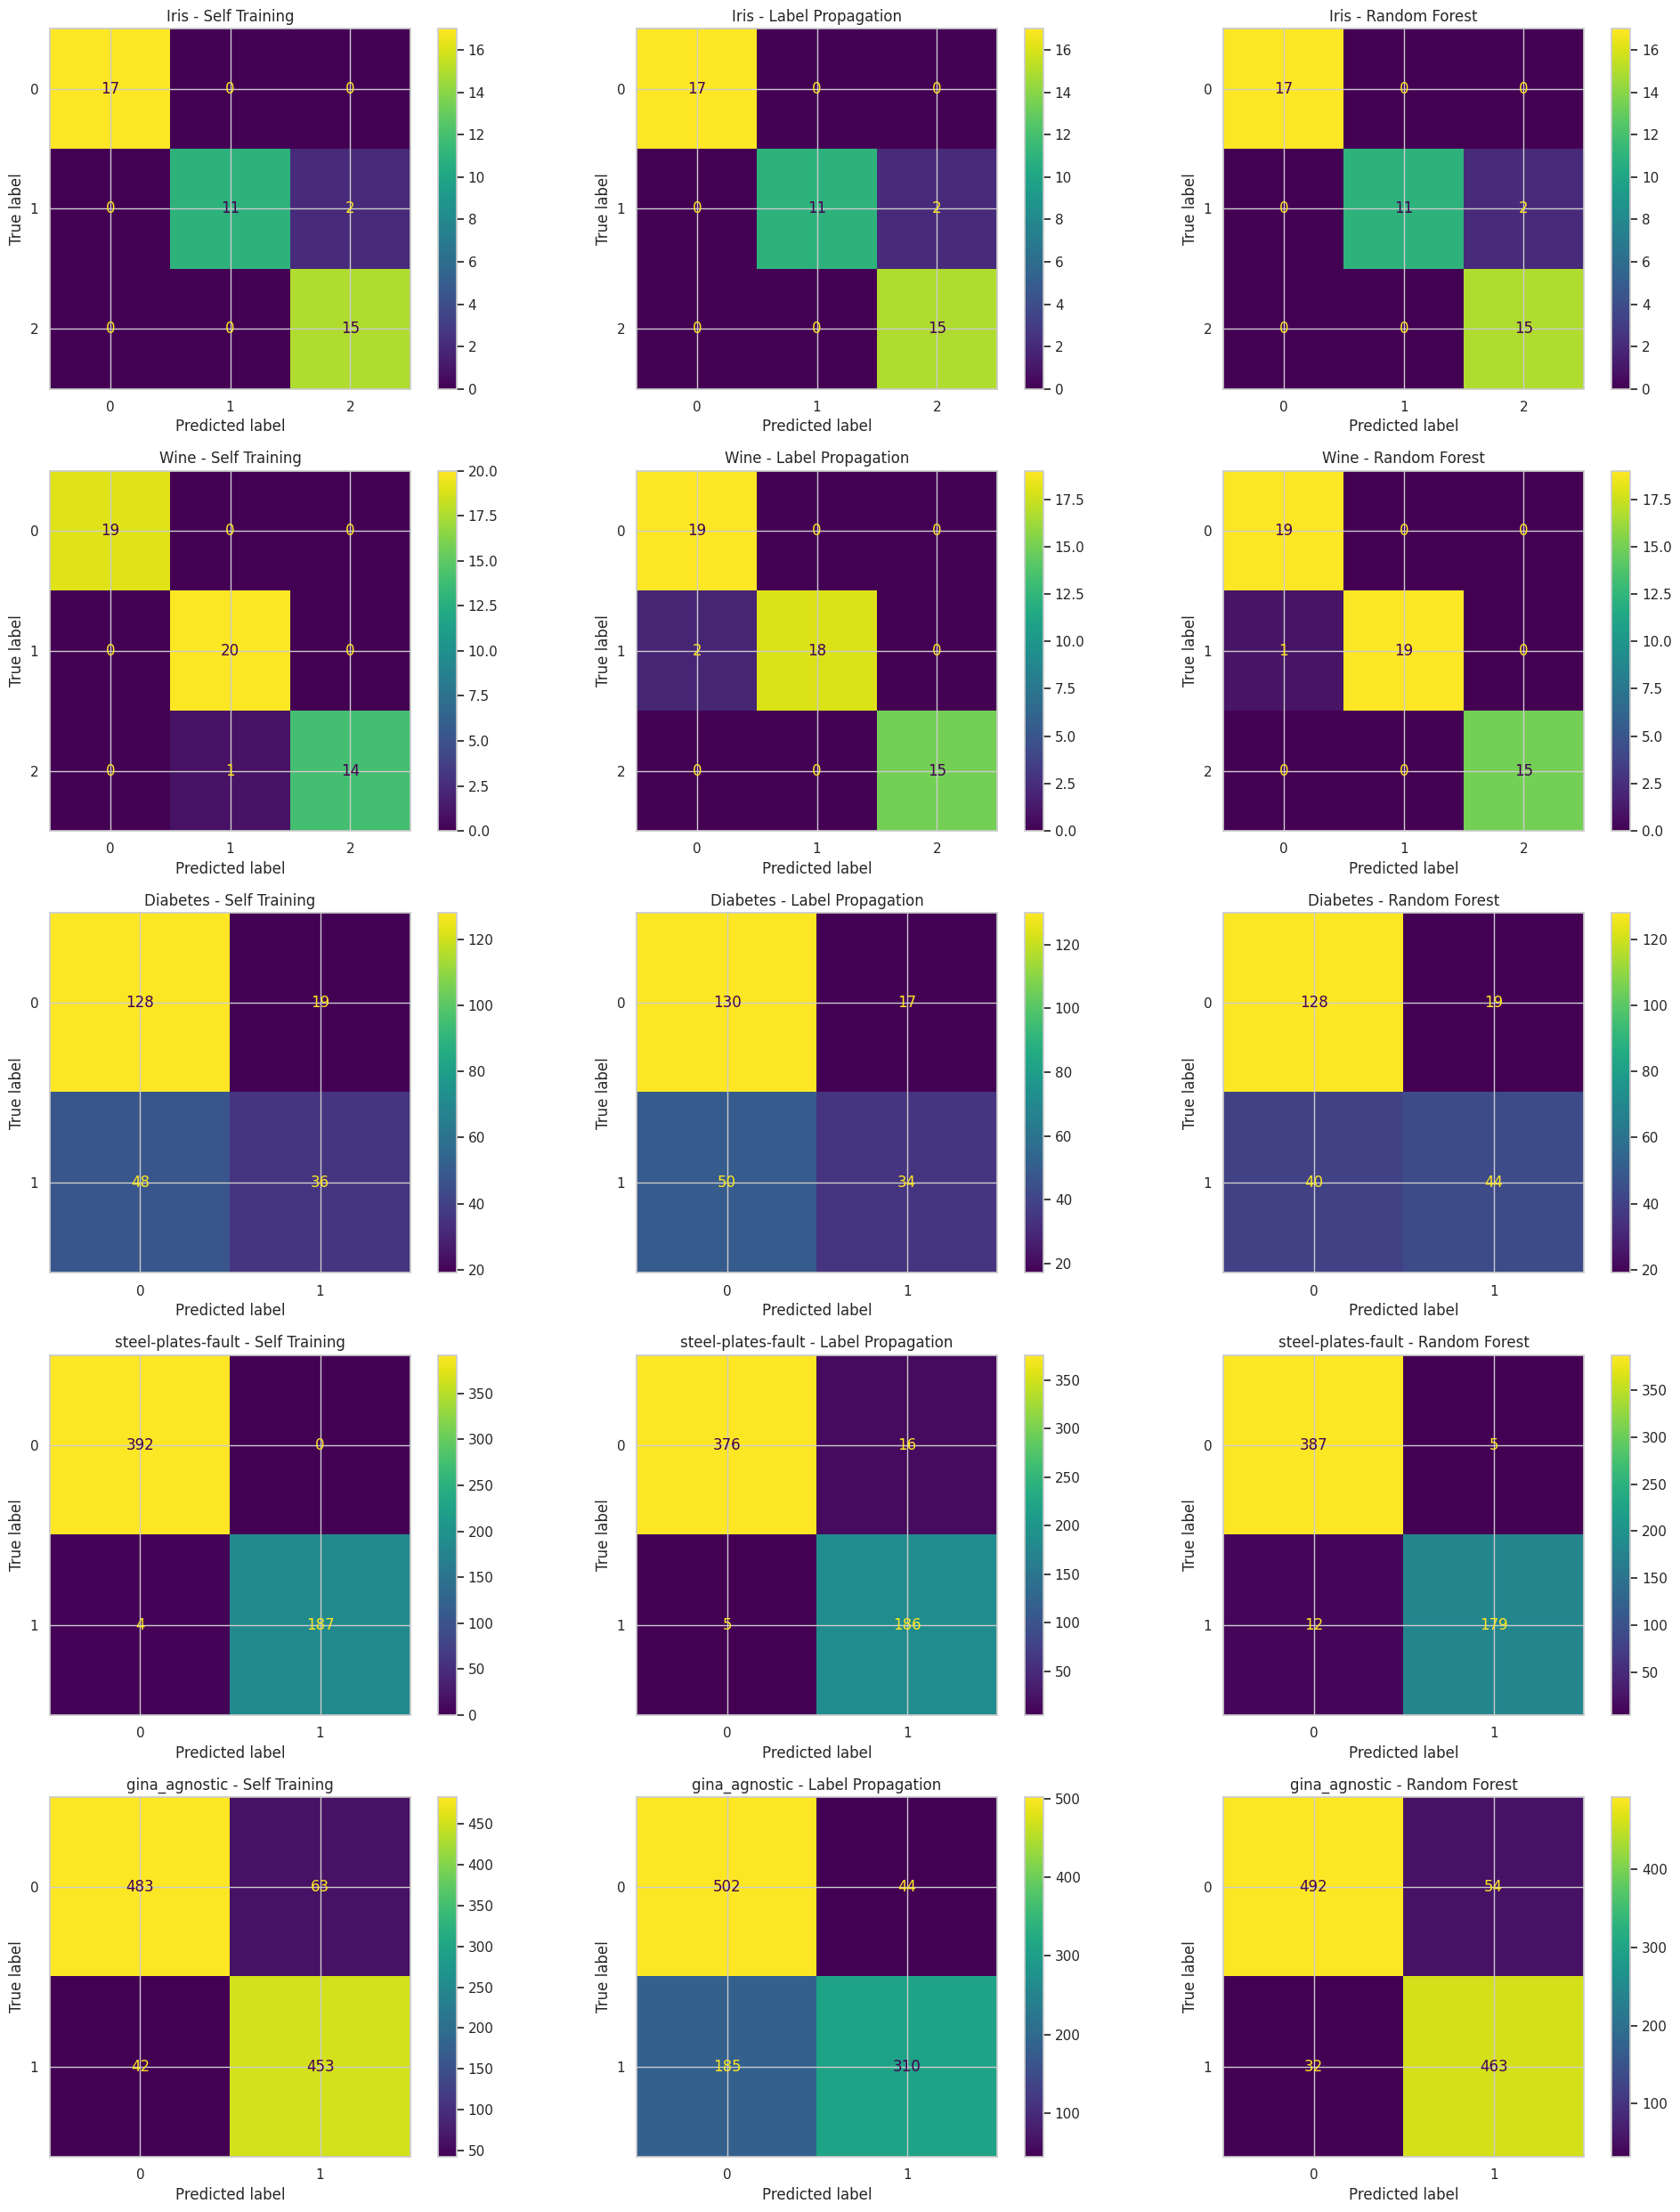

### 25% Etiquetas eliminadas

En este caso, he eliminado el 25% de las etiquetas. Al contar con aún más datos etiquetados, se espera que Random Forest tenga un mejor desempeño.

*   **Iris**: Self Training obtiene el mejor rendimiento con una accuracy de 0.9778, mientras que Label Propagation y Random Forest tienen un rendimiento idéntico y ligeramente inferior. Esto podría sugerir que Self Training logra aprovechar mejor la información adicional proporcionada por las etiquetas eliminadas. Aunque al ser Iris un dataset tan sencillo con tan pocos registros, simplemente podría ser producto del azar que Self Training fuese el mejor clasificador este caso.

*   **Wine**: Tanto Self Training como Random Forest alcanzan un rendimiento excelente, con valores idénticos en todas las métricas. Label Propagation tiene un rendimiento ligeramente inferior como se comentó para el 50% de etiquetas eliminadas.

*   **Diabetes**: Self Training muestra el mejor rendimiento en este caso, superando tanto a Random Forest como a Label Propagation. Esto representa un cambio respecto a las configuraciones con menos etiquetas, donde Random Forest era el mejor modelo. Esto podría deberse a unas instancias especificas que han sido eliminadas y representan un información muy útil para los modelos que no la tendría Random Forest. Sin embargo, ninguna de las métricas alcanza valores óptimos, indicando que este conjunto de datos sigue siendo un reto.

*   **Steel Plates Fault**: En este dataset, Random Forest es ahora el mejor modelo, con una accuracy de 0.9931, mientras que Self Training también presenta un rendimiento sobresaliente. Label Propagation, aunque sigue siendo fuerte, muestra una ligera desventaja respecto a los otros métodos.

*  **Gina Agnostic**: Random Forest sigue siendo el mejor clasificador con una accuracy de 0.9212, mientras que Self Training se mantiene competitivo. Label Propagation, aunque ha mejorado con respecto a los experimentos anteriores, sigue siendo el modelo con peor desempeño, lo que confirma que un enfoque supervisado es más adecuado para este dataset.

<table border="1">
  <tr>
    <th>Modelo</th>
    <th>Dataset</th>
    <th>Accuracy</th>
    <th>Precisión</th>
    <th>Recall</th>
    <th>F1 Score</th>
  </tr>
  <tr>
    <td>Self Training</td>
    <td>Iris</td>
    <td>0.9778</td>
    <td>0.9792</td>
    <td>0.9778</td>
    <td>0.9777</td>
  </tr>
  <tr>
    <td>Label Propagation</td>
    <td>Iris</td>
    <td>0.9556</td>
    <td>0.9608</td>
    <td>0.9556</td>
    <td>0.9551</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>Iris</td>
    <td>0.9556</td>
    <td>0.9608</td>
    <td>0.9556</td>
    <td>0.9551</td>
  </tr>
  <tr>
    <td>Self Training</td>
    <td>Wine</td>
    <td>0.9815</td>
    <td>0.9824</td>
    <td>0.9815</td>
    <td>0.9814</td>
  </tr>
  <tr>
    <td>Label Propagation</td>
    <td>Wine</td>
    <td>0.9630</td>
    <td>0.9665</td>
    <td>0.9630</td>
    <td>0.9629</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>Wine</td>
    <td>0.9815</td>
    <td>0.9824</td>
    <td>0.9815</td>
    <td>0.9815</td>
  </tr>
  <tr>
    <td>Self Training</td>
    <td>Diabetes</td>
    <td>0.7619</td>
    <td>0.7596</td>
    <td>0.7619</td>
    <td>0.7504</td>
  </tr>
  <tr>
    <td>Label Propagation</td>
    <td>Diabetes</td>
    <td>0.6970</td>
    <td>0.6877</td>
    <td>0.6970</td>
    <td>0.6888</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>Diabetes</td>
    <td>0.7489</td>
    <td>0.7432</td>
    <td>0.7489</td>
    <td>0.7422</td>
  </tr>
  <tr>
    <td>Self Training</td>
    <td>steel-plates-fault</td>
    <td>0.9914</td>
    <td>0.9915</td>
    <td>0.9914</td>
    <td>0.9914</td>
  </tr>
  <tr>
    <td>Label Propagation</td>
    <td>steel-plates-fault</td>
    <td>0.9708</td>
    <td>0.9720</td>
    <td>0.9708</td>
    <td>0.9710</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>steel-plates-fault</td>
    <td>0.9931</td>
    <td>0.9932</td>
    <td>0.9931</td>
    <td>0.9931</td>
  </tr>
  <tr>
    <td>Self Training</td>
    <td>gina_agnostic</td>
    <td>0.9049</td>
    <td>0.9056</td>
    <td>0.9049</td>
    <td>0.9050</td>
  </tr>
  <tr>
    <td>Label Propagation</td>
    <td>gina_agnostic</td>
    <td>0.8060</td>
    <td>0.8174</td>
    <td>0.8060</td>
    <td>0.8029</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>gina_agnostic</td>
    <td>0.9212</td>
    <td>0.9217</td>
    <td>0.9212</td>
    <td>0.9213</td>
  </tr>
</table>


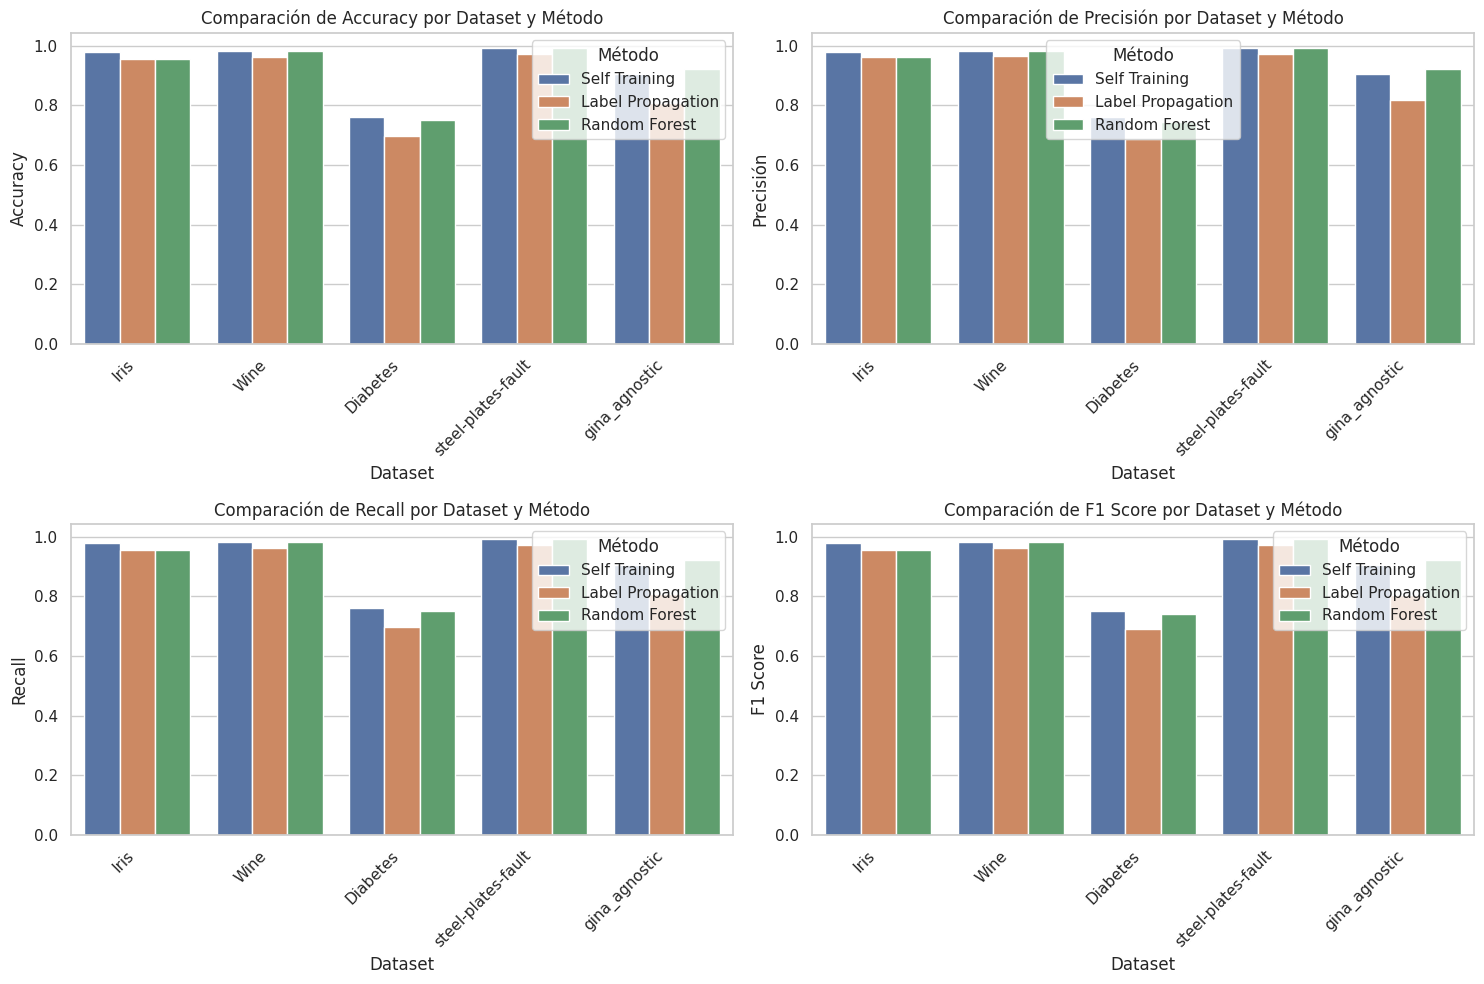

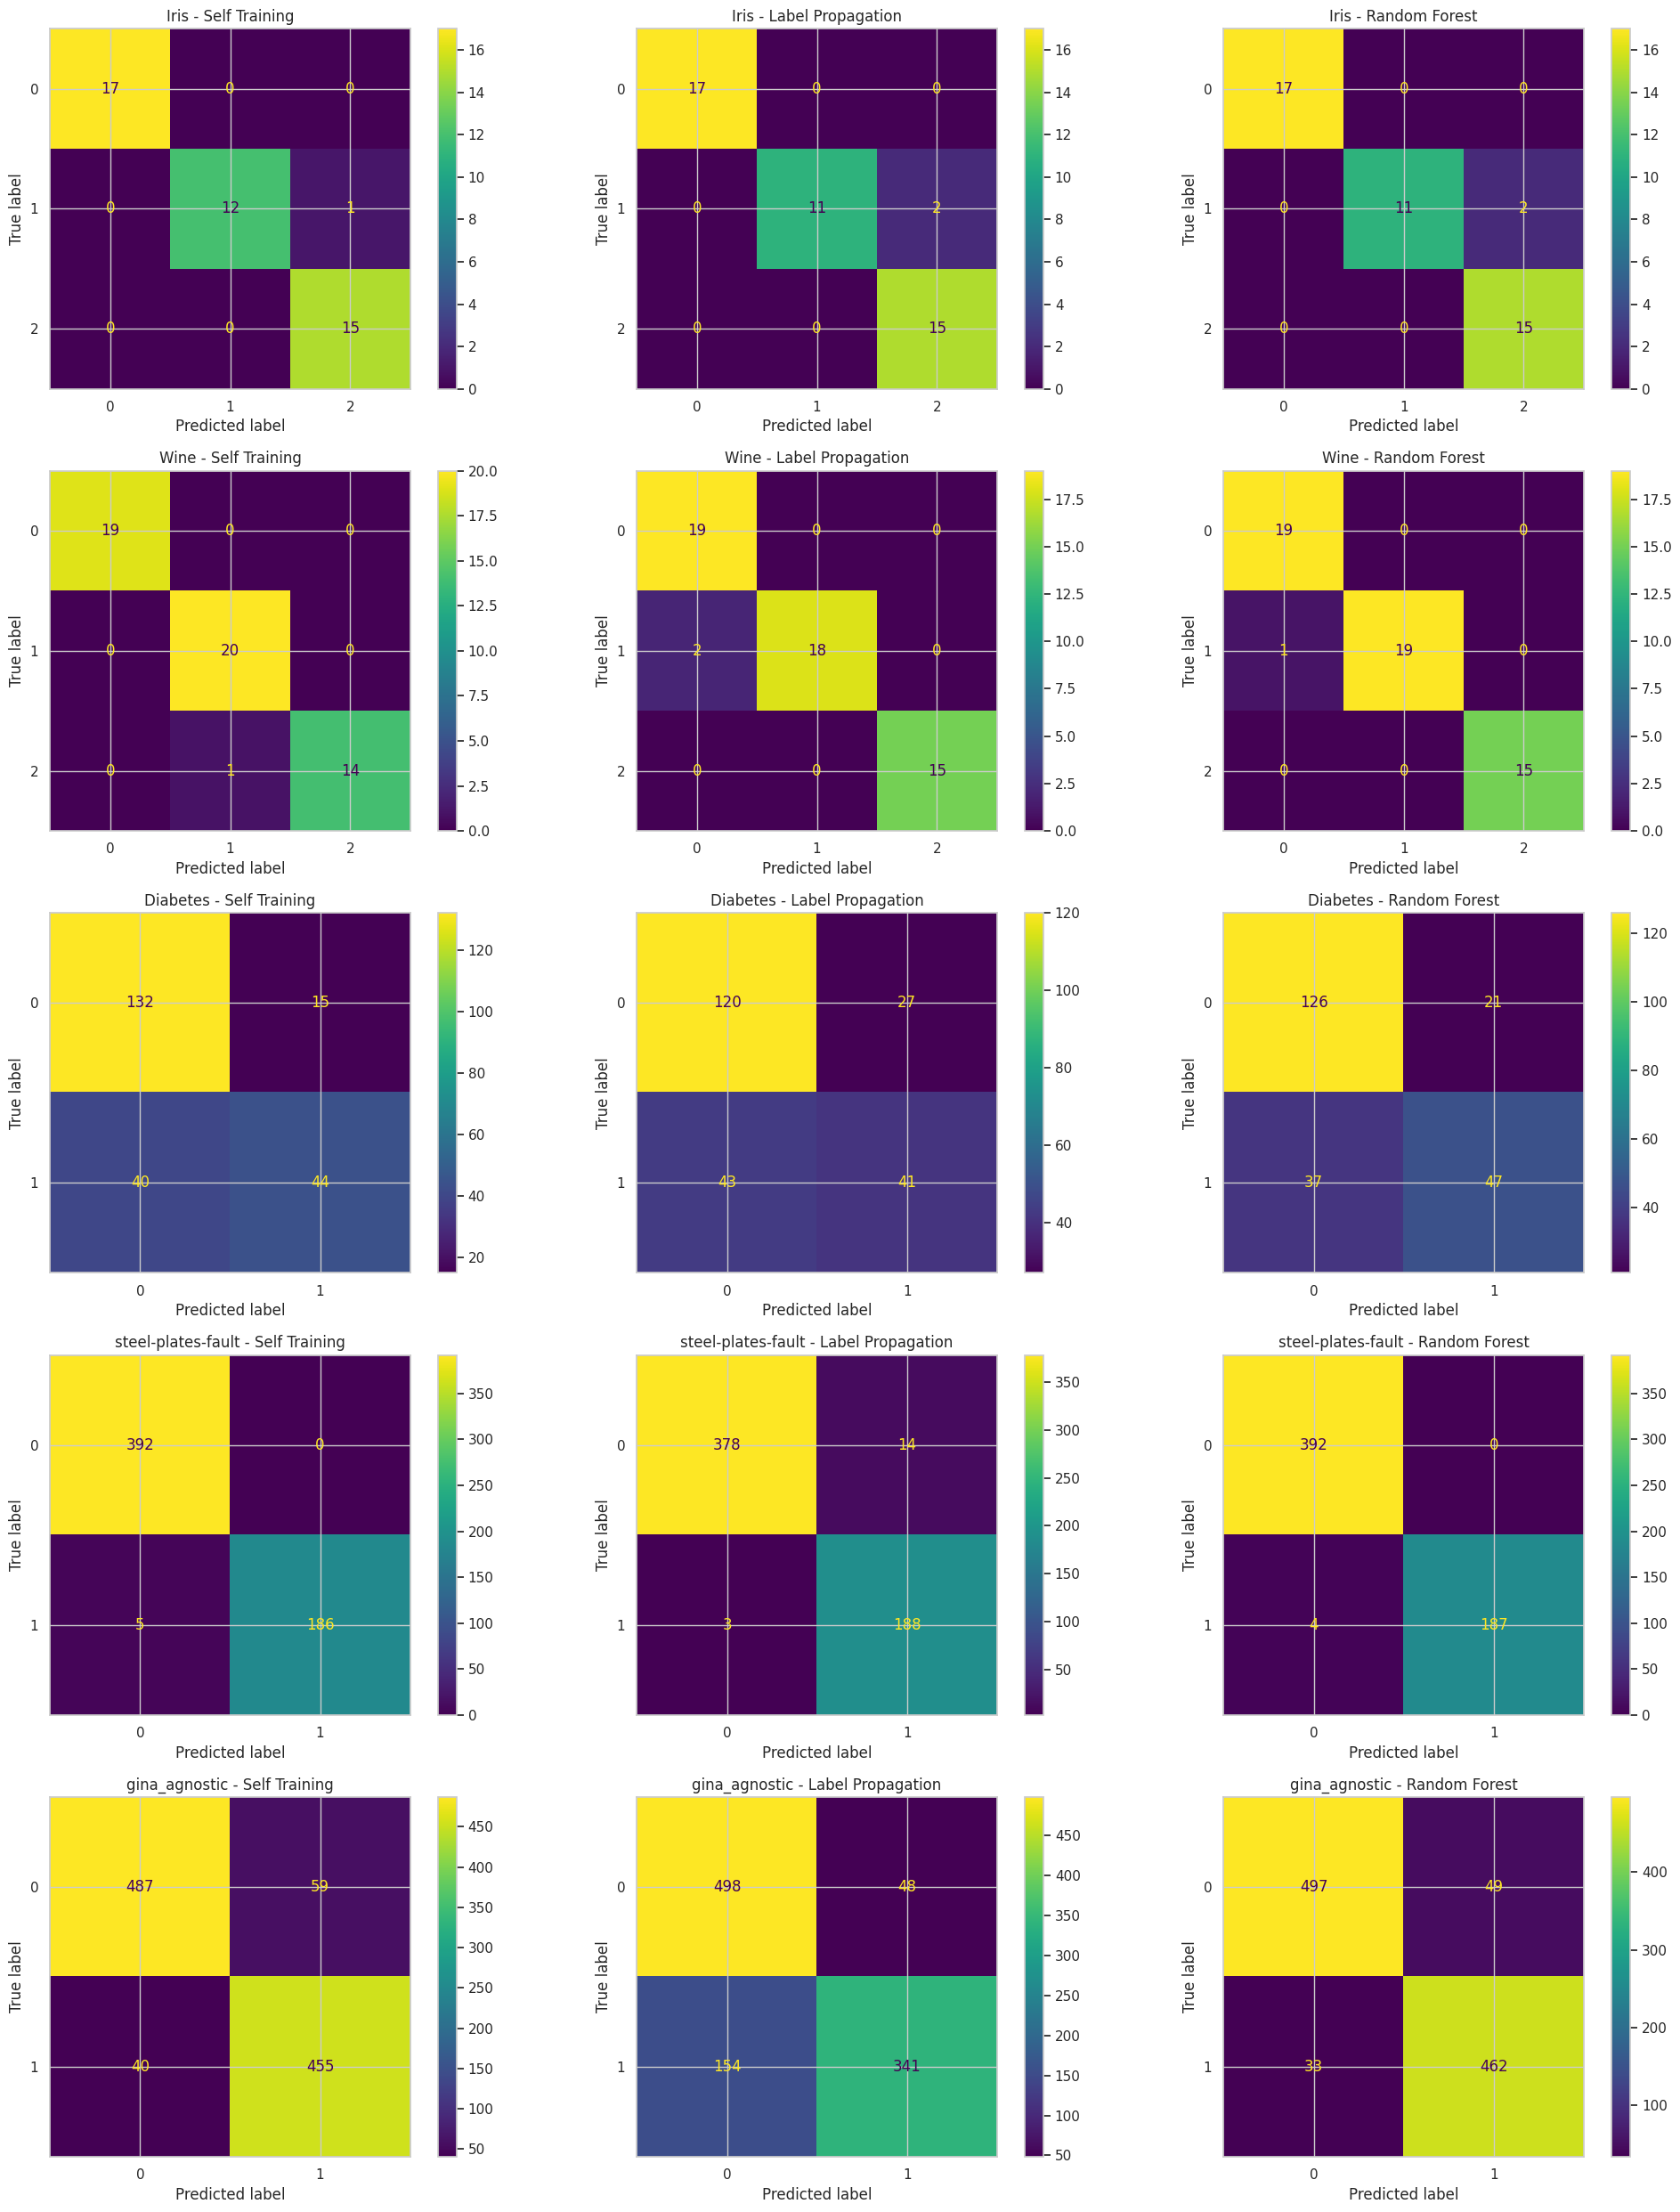

### Conclusión general

Los clasificadores semi-supervisados son una gran herramienta para trabajar con dataset con una gran carencia de etiquetas. Sin embargo, hay conjuntos de datos en los que, al menos los algoritmos probados, no presentan una mejor actuación que clasificadores supervisados a los que se les ha eliminado las instancias sin etiquetas.

En definitiva, si contamos con un dataset caracterizado por una falta de etiquetas notable, merecera la pena probar métodos semi-supervisados. Aunque habrá conjuntos de datos (como Gina Agnostic) que, por la naturaleza del problema, eliminar las instancias no etiquetadas y usar un clasificador supervisado será una mejor opción.